In [1]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
import pandas as pd
# from gptide import cov
from gptide import GPtideScipy
from gptide import stats as gpstats
from scipy import signal as sg
from s3fs import S3FileSystem, S3Map
import scipy
from scipy import stats
from scipy.special import kv as K_nu
from scipy.special import gamma
from scipy.optimize import minimize
# mle function import
from IPython.display import display, HTML
display(HTML("<style>.container { width:80% !important; }</style>"))

C:\Users\21924032\Anaconda3\lib\site-packages\xarray\backends\cfgrib_.py:27: UserWarning: Failed to load cfgrib - most likely there is a problem accessing the ecCodes library. Try `import cfgrib` to get the full error message
  warnings.warn(


In [2]:
plt.rcParams['axes.labelsize'] = 'medium'
plt.rcParams['font.size'] = 14
plt.rcParams['figure.figsize'] = [25, 10]
#np.set_printoptions(threshold=sys.maxsize)
plt.rcParams['animation.embed_limit'] = 2**128

# Import raw observation data and PSD processing

The raw observation data is extracted from IMOS open access ocean data at Australia NWS 400km offshore

In [3]:
# Login to the s3 bucket and list the deep water mooring (DWM) folders
fs = S3FileSystem(anon=True)
aodn = fs.ls('imos-data/IMOS/DWM/')
for item in aodn:
    print(item)

imos-data/IMOS/DWM/ASFS
imos-data/IMOS/DWM/DA
imos-data/IMOS/DWM/SOTS


- P1: 2012-02-02 ---- 2012-08-09
- P2: 2012-08-10 ---- 2012-12-08
- P3: 2013-01-24  ---- 2013-07-23
- P4: 2013-07-24  ---- 2014-02-01
- P5: 2014-01-31  ---- 2014-08-24

In [4]:
P1_start = '2012-02-04'
P2_start = '2012-08-11'
P3_start = '2013-01-25'
P4_start = '2013-07-25'
P5_start = '2014-02-01'

In [5]:
## Australia NWS
KIM400_temp_ncfiles_P1 = [
'imos-data/IMOS/ANMN/QLD/KIM400/Temperature/IMOS_ANMN-QLD_TZ_20120202T000000Z_KIM400_FV01_KIM400-1202-SBE39-59_END-20120809T114600Z_C-20171204T063704Z.nc',
'imos-data/IMOS/ANMN/QLD/KIM400/Temperature/IMOS_ANMN-QLD_TZ_20120202T000000Z_KIM400_FV01_KIM400-1202-SBE56-299_END-20120810T042859Z_C-20171204T063629Z.nc',
'imos-data/IMOS/ANMN/QLD/KIM400/Temperature/IMOS_ANMN-QLD_TZ_20120202T000000Z_KIM400_FV01_KIM400-1202-SBE56-392_END-20120810T004259Z_C-20171204T063608Z.nc',
'imos-data/IMOS/ANMN/QLD/KIM400/Temperature/IMOS_ANMN-QLD_TZ_20120202T000000Z_KIM400_FV01_KIM400-1202-SBE56-49_END-20120810T034459Z_C-20171204T063707Z.nc',
'imos-data/IMOS/ANMN/QLD/KIM400/Temperature/IMOS_ANMN-QLD_TZ_20120202T000000Z_KIM400_FV01_KIM400-1202-SBE56-69_END-20120810T031159Z_C-20171204T063701Z.nc',
'imos-data/IMOS/ANMN/QLD/KIM400/Temperature/IMOS_ANMN-QLD_TZ_20120202T000000Z_KIM400_FV01_KIM400-1202-SBE56-89_END-20120810T015546Z_C-20171204T063655Z.nc',
'imos-data/IMOS/ANMN/QLD/KIM400/Temperature/IMOS_ANMN-QLD_TZ_20120202T120000Z_KIM400_FV01_KIM400-1202-SBE39-29_END-20120809T234200Z_C-20171204T063713Z.nc',
'imos-data/IMOS/ANMN/QLD/KIM400/Temperature/IMOS_ANMN-QLD_TZ_20120202T120000Z_KIM400_FV01_KIM400-1202-SBE39-79_END-20120809T042400Z_C-20171204T063658Z.nc',
'imos-data/IMOS/ANMN/QLD/KIM400/Temperature/IMOS_ANMN-QLD_TZ_20120202T120000Z_KIM400_FV01_KIM400-1202-SBE56-372_END-20120810T031359Z_C-20171204T063620Z.nc',
'imos-data/IMOS/ANMN/QLD/KIM400/Temperature/IMOS_ANMN-QLD_TZ_20120203T000000Z_KIM400_FV01_KIM400-1202-SBE56-124_END-20120810T015557Z_C-20171204T063649Z.nc',
'imos-data/IMOS/ANMN/QLD/KIM400/Temperature/IMOS_ANMN-QLD_TZ_20120203T000000Z_KIM400_FV01_KIM400-1202-SBE56-149_END-20120810T015659Z_C-20171204T063646Z.nc',
'imos-data/IMOS/ANMN/QLD/KIM400/Temperature/IMOS_ANMN-QLD_TZ_20120203T000000Z_KIM400_FV01_KIM400-1202-SBE56-174_END-20120810T015259Z_C-20171204T063643Z.nc',
'imos-data/IMOS/ANMN/QLD/KIM400/Temperature/IMOS_ANMN-QLD_TZ_20120203T000000Z_KIM400_FV01_KIM400-1202-SBE56-224_END-20120810T042959Z_C-20171204T063637Z.nc',
'imos-data/IMOS/ANMN/QLD/KIM400/Temperature/IMOS_ANMN-QLD_TZ_20120203T000000Z_KIM400_FV01_KIM400-1202-SBE56-249_END-20120810T024559Z_C-20171204T063634Z.nc',
'imos-data/IMOS/ANMN/QLD/KIM400/Temperature/IMOS_ANMN-QLD_TZ_20120203T000000Z_KIM400_FV01_KIM400-1202-SBE56-274_END-20120810T004759Z_C-20171204T063631Z.nc',
'imos-data/IMOS/ANMN/QLD/KIM400/Temperature/IMOS_ANMN-QLD_TZ_20120203T000000Z_KIM400_FV01_KIM400-1202-SBE56-324_END-20120810T034659Z_C-20171204T063626Z.nc',
'imos-data/IMOS/ANMN/QLD/KIM400/Temperature/IMOS_ANMN-QLD_TZ_20120203T000000Z_KIM400_FV01_KIM400-1202-SBE56-349_END-20120810T031259Z_C-20171204T063623Z.nc',]

In [6]:
## Australia NWS
KIM400_temp_ncfiles_P2 = [
'imos-data/IMOS/ANMN/QLD/KIM400/Temperature/IMOS_ANMN-QLD_TZ_20120720T100000Z_KIM400_FV01_KIM400-1208-SBE56-298_END-20130128T012549Z_C-20171205T063330Z.nc',
'imos-data/IMOS/ANMN/QLD/KIM400/Temperature/IMOS_ANMN-QLD_TZ_20120720T100000Z_KIM400_FV01_KIM400-1208-SBE56-323_END-20130127T085831Z_C-20171205T063326Z.nc',
'imos-data/IMOS/ANMN/QLD/KIM400/Temperature/IMOS_ANMN-QLD_TZ_20120720T100000Z_KIM400_FV01_KIM400-1208-SBE56-348_END-20130128T015849Z_C-20171205T063323Z.nc',
'imos-data/IMOS/ANMN/QLD/KIM400/Temperature/IMOS_ANMN-QLD_TZ_20120806T000000Z_KIM400_FV01_KIM400-1208-SBE56-123_END-20130128T020859Z_C-20171205T063353Z.nc',
'imos-data/IMOS/ANMN/QLD/KIM400/Temperature/IMOS_ANMN-QLD_TZ_20120806T000000Z_KIM400_FV01_KIM400-1208-SBE56-148_END-20130128T020436Z_C-20171205T063350Z.nc',
'imos-data/IMOS/ANMN/QLD/KIM400/Temperature/IMOS_ANMN-QLD_TZ_20120806T000000Z_KIM400_FV01_KIM400-1208-SBE56-173_END-20130128T013048Z_C-20171205T063346Z.nc',
'imos-data/IMOS/ANMN/QLD/KIM400/Temperature/IMOS_ANMN-QLD_TZ_20120806T000000Z_KIM400_FV01_KIM400-1208-SBE56-223_END-20130127T094728Z_C-20171205T063339Z.nc',
'imos-data/IMOS/ANMN/QLD/KIM400/Temperature/IMOS_ANMN-QLD_TZ_20120806T000000Z_KIM400_FV01_KIM400-1208-SBE56-248_END-20130128T015332Z_C-20171205T063336Z.nc',
'imos-data/IMOS/ANMN/QLD/KIM400/Temperature/IMOS_ANMN-QLD_TZ_20120806T000000Z_KIM400_FV01_KIM400-1208-SBE56-273_END-20130128T011408Z_C-20171205T063333Z.nc',
'imos-data/IMOS/ANMN/QLD/KIM400/Temperature/IMOS_ANMN-QLD_TZ_20120806T000000Z_KIM400_FV01_KIM400-1208-SBE56-48_END-20130128T014728Z_C-20171205T063413Z.nc',
'imos-data/IMOS/ANMN/QLD/KIM400/Temperature/IMOS_ANMN-QLD_TZ_20120806T000000Z_KIM400_FV01_KIM400-1208-SBE56-68_END-20130128T004959Z_C-20171205T063406Z.nc',
'imos-data/IMOS/ANMN/QLD/KIM400/Temperature/IMOS_ANMN-QLD_TZ_20120806T000000Z_KIM400_FV01_KIM400-1208-SBE56-78_END-20130128T011908Z_C-20171205T063403Z.nc',
'imos-data/IMOS/ANMN/QLD/KIM400/Temperature/IMOS_ANMN-QLD_TZ_20120806T000000Z_KIM400_FV01_KIM400-1208-SBE56-88_END-20130128T003958Z_C-20171205T063400Z.nc',
'imos-data/IMOS/ANMN/QLD/KIM400/Temperature/IMOS_ANMN-QLD_TZ_20120810T220000Z_KIM400_FV01_KIM400-1208-SBE39-28_END-20130128T024800Z_C-20171205T063420Z.nc',
'imos-data/IMOS/ANMN/QLD/KIM400/Temperature/IMOS_ANMN-QLD_TZ_20120810T220000Z_KIM400_FV01_KIM400-1208-SBE39-58_END-20130128T031400Z_C-20171205T063410Z.nc',
'imos-data/IMOS/ANMN/QLD/KIM400/Temperature/IMOS_ANMN-QLD_TZ_20120810T220000Z_KIM400_FV01_KIM400-1208-SBE56-373_END-20130127T093558Z_C-20171205T063320Z.nc',
'imos-data/IMOS/ANMN/QLD/KIM400/Temperature/IMOS_ANMN-QLD_TZ_20120810T220000Z_KIM400_FV01_KIM400-1208-SBE56-391_END-20130128T013558Z_C-20171205T063306Z.nc',
]

In [7]:
KIM400_temp_ncfiles_P3 = [
'imos-data/IMOS/ANMN/QLD/KIM400/Temperature/IMOS_ANMN-QLD_TZ_20130124T000000Z_KIM400_FV01_KIM400-1301-SBE56-123_END-20130722T065101Z_C-20171205T080703Z.nc',
'imos-data/IMOS/ANMN/QLD/KIM400/Temperature/IMOS_ANMN-QLD_TZ_20130124T000000Z_KIM400_FV01_KIM400-1301-SBE56-148_END-20130722T081549Z_C-20171205T080700Z.nc',
'imos-data/IMOS/ANMN/QLD/KIM400/Temperature/IMOS_ANMN-QLD_TZ_20130124T000000Z_KIM400_FV01_KIM400-1301-SBE56-173_END-20130722T081409Z_C-20171205T080657Z.nc',
'imos-data/IMOS/ANMN/QLD/KIM400/Temperature/IMOS_ANMN-QLD_TZ_20130124T000000Z_KIM400_FV01_KIM400-1301-SBE56-223_END-20130722T082639Z_C-20171205T080651Z.nc',
'imos-data/IMOS/ANMN/QLD/KIM400/Temperature/IMOS_ANMN-QLD_TZ_20130124T000000Z_KIM400_FV01_KIM400-1301-SBE56-248_END-20130722T062909Z_C-20171205T080648Z.nc',
'imos-data/IMOS/ANMN/QLD/KIM400/Temperature/IMOS_ANMN-QLD_TZ_20130124T000000Z_KIM400_FV01_KIM400-1301-SBE56-273_END-20130722T074139Z_C-20171205T080645Z.nc',
'imos-data/IMOS/ANMN/QLD/KIM400/Temperature/IMOS_ANMN-QLD_TZ_20130124T000000Z_KIM400_FV01_KIM400-1301-SBE56-298_END-20130722T073049Z_C-20171205T080642Z.nc',
'imos-data/IMOS/ANMN/QLD/KIM400/Temperature/IMOS_ANMN-QLD_TZ_20130124T000000Z_KIM400_FV01_KIM400-1301-SBE56-323_END-20130722T071409Z_C-20171205T080639Z.nc',
'imos-data/IMOS/ANMN/QLD/KIM400/Temperature/IMOS_ANMN-QLD_TZ_20130124T000000Z_KIM400_FV01_KIM400-1301-SBE56-348_END-20130722T063959Z_C-20171205T080636Z.nc',
'imos-data/IMOS/ANMN/QLD/KIM400/Temperature/IMOS_ANMN-QLD_TZ_20130124T000000Z_KIM400_FV01_KIM400-1301-SBE56-373_END-20130722T062229Z_C-20171205T080633Z.nc',
'imos-data/IMOS/ANMN/QLD/KIM400/Temperature/IMOS_ANMN-QLD_TZ_20130124T000000Z_KIM400_FV01_KIM400-1301-SBE56-391_END-20130722T074049Z_C-20171205T080620Z.nc',
'imos-data/IMOS/ANMN/QLD/KIM400/Temperature/IMOS_ANMN-QLD_TZ_20130124T000000Z_KIM400_FV01_KIM400-1301-SBE56-48_END-20130722T083909Z_C-20171205T080722Z.nc',
'imos-data/IMOS/ANMN/QLD/KIM400/Temperature/IMOS_ANMN-QLD_TZ_20130124T000000Z_KIM400_FV01_KIM400-1301-SBE56-68_END-20130722T083639Z_C-20171205T080716Z.nc',
'imos-data/IMOS/ANMN/QLD/KIM400/Temperature/IMOS_ANMN-QLD_TZ_20130124T000000Z_KIM400_FV01_KIM400-1301-SBE56-78_END-20130722T071319Z_C-20171205T080713Z.nc',
'imos-data/IMOS/ANMN/QLD/KIM400/Temperature/IMOS_ANMN-QLD_TZ_20130124T000000Z_KIM400_FV01_KIM400-1301-SBE56-88_END-20130722T085049Z_C-20171205T080710Z.nc',
'imos-data/IMOS/ANMN/QLD/KIM400/Temperature/IMOS_ANMN-QLD_TZ_20130125T000000Z_KIM400_FV01_KIM400-1301-SBE39-58_END-20130723T064400Z_C-20171205T080719Z.nc',
]

In [8]:
KIM400_temp_ncfiles_P4 = [
'imos-data/IMOS/ANMN/QLD/KIM400/Temperature/IMOS_ANMN-QLD_TZ_20130724T000000Z_KIM400_FV01_KIM400-1307-SBE56-84_END-20140130T060948Z_C-20171205T092501Z.nc',    
'imos-data/IMOS/ANMN/QLD/KIM400/Temperature/IMOS_ANMN-QLD_TZ_20130724T000000Z_KIM400_FV01_KIM400-1307-SBE56-119_END-20140130T004451Z_C-20171205T092454Z.nc',
'imos-data/IMOS/ANMN/QLD/KIM400/Temperature/IMOS_ANMN-QLD_TZ_20130724T000000Z_KIM400_FV01_KIM400-1307-SBE56-144_END-20140129T092959Z_C-20171205T092451Z.nc',
'imos-data/IMOS/ANMN/QLD/KIM400/Temperature/IMOS_ANMN-QLD_TZ_20130724T000000Z_KIM400_FV01_KIM400-1307-SBE56-169_END-20140130T035459Z_C-20171205T092448Z.nc',
'imos-data/IMOS/ANMN/QLD/KIM400/Temperature/IMOS_ANMN-QLD_TZ_20130724T000000Z_KIM400_FV01_KIM400-1307-SBE56-219_END-20140130T060049Z_C-20171205T092441Z.nc',
'imos-data/IMOS/ANMN/QLD/KIM400/Temperature/IMOS_ANMN-QLD_TZ_20130724T000000Z_KIM400_FV01_KIM400-1307-SBE56-244_END-20140130T035959Z_C-20171205T092438Z.nc',
'imos-data/IMOS/ANMN/QLD/KIM400/Temperature/IMOS_ANMN-QLD_TZ_20130724T000000Z_KIM400_FV01_KIM400-1307-SBE56-24_END-20140130T035222Z_C-20171205T092520Z.nc',
'imos-data/IMOS/ANMN/QLD/KIM400/Temperature/IMOS_ANMN-QLD_TZ_20130724T000000Z_KIM400_FV01_KIM400-1307-SBE56-269_END-20140130T055909Z_C-20171205T092435Z.nc',
'imos-data/IMOS/ANMN/QLD/KIM400/Temperature/IMOS_ANMN-QLD_TZ_20130724T000000Z_KIM400_FV01_KIM400-1307-SBE56-294_END-20140130T041139Z_C-20171205T092432Z.nc',
'imos-data/IMOS/ANMN/QLD/KIM400/Temperature/IMOS_ANMN-QLD_TZ_20130724T000000Z_KIM400_FV01_KIM400-1307-SBE56-319_END-20140130T041319Z_C-20171205T092429Z.nc',
'imos-data/IMOS/ANMN/QLD/KIM400/Temperature/IMOS_ANMN-QLD_TZ_20130724T000000Z_KIM400_FV01_KIM400-1307-SBE56-344_END-20140130T054409Z_C-20171205T092425Z.nc',
'imos-data/IMOS/ANMN/QLD/KIM400/Temperature/IMOS_ANMN-QLD_TZ_20130724T000000Z_KIM400_FV01_KIM400-1307-SBE56-369_END-20140129T092908Z_C-20171205T092422Z.nc',
'imos-data/IMOS/ANMN/QLD/KIM400/Temperature/IMOS_ANMN-QLD_TZ_20130724T000000Z_KIM400_FV01_KIM400-1307-SBE56-387_END-20140130T011819Z_C-20171205T092409Z.nc',
'imos-data/IMOS/ANMN/QLD/KIM400/Temperature/IMOS_ANMN-QLD_TZ_20130724T000000Z_KIM400_FV01_KIM400-1307-SBE56-44_END-20140130T034511Z_C-20171205T092514Z.nc',
'imos-data/IMOS/ANMN/QLD/KIM400/Temperature/IMOS_ANMN-QLD_TZ_20130724T000000Z_KIM400_FV01_KIM400-1307-SBE56-64_END-20140129T093049Z_C-20171205T092507Z.nc',
'imos-data/IMOS/ANMN/QLD/KIM400/Temperature/IMOS_ANMN-QLD_TZ_20130725T000000Z_KIM400_FV01_KIM400-1307-SBE39-54_END-20140201T102800Z_C-20171205T092510Z.nc',
'imos-data/IMOS/ANMN/QLD/KIM400/Temperature/IMOS_ANMN-QLD_TZ_20130725T000000Z_KIM400_FV01_KIM400-1307-SBE39-74_END-20140201T115400Z_C-20171205T092504Z.nc',
]

In [9]:
KIM400_temp_ncfiles_P5 = [
'imos-data/IMOS/ANMN/QLD/KIM400/Temperature/IMOS_ANMN-QLD_TZ_20140111T000000Z_KIM400_FV01_KIM400-1401-SBE56-391.4_END-20140824T071629Z_C-20171211T020550Z.nc',
'imos-data/IMOS/ANMN/QLD/KIM400/Temperature/IMOS_ANMN-QLD_TZ_20140115T000000Z_KIM400_FV01_KIM400-1401-SBE56-123.4_END-20140824T080229Z_C-20171211T020635Z.nc',
'imos-data/IMOS/ANMN/QLD/KIM400/Temperature/IMOS_ANMN-QLD_TZ_20140115T000000Z_KIM400_FV01_KIM400-1401-SBE56-148.4_END-20140824T064759Z_C-20171211T020632Z.nc',
'imos-data/IMOS/ANMN/QLD/KIM400/Temperature/IMOS_ANMN-QLD_TZ_20140115T000000Z_KIM400_FV01_KIM400-1401-SBE56-173.4_END-20140824T084629Z_C-20171211T020629Z.nc',
'imos-data/IMOS/ANMN/QLD/KIM400/Temperature/IMOS_ANMN-QLD_TZ_20140115T000000Z_KIM400_FV01_KIM400-1401-SBE56-223.4_END-20140824T083129Z_C-20171211T020622Z.nc',
'imos-data/IMOS/ANMN/QLD/KIM400/Temperature/IMOS_ANMN-QLD_TZ_20140115T000000Z_KIM400_FV01_KIM400-1401-SBE56-28.4_END-20140824T074529Z_C-20171211T020702Z.nc',
'imos-data/IMOS/ANMN/QLD/KIM400/Temperature/IMOS_ANMN-QLD_TZ_20140115T000000Z_KIM400_FV01_KIM400-1401-SBE56-48.4_END-20140824T073129Z_C-20171211T020655Z.nc',
# 'imos-data/IMOS/ANMN/QLD/KIM400/Temperature/IMOS_ANMN-QLD_TZ_20140115T000000Z_KIM400_FV01_KIM400-1401-SBE56-68.4_END-20140824T093929Z_C-20171211T020648Z.nc',
'imos-data/IMOS/ANMN/QLD/KIM400/Temperature/IMOS_ANMN-QLD_TZ_20140115T000000Z_KIM400_FV01_KIM400-1401-SBE56-88.4_END-20140824T090329Z_C-20171211T020642Z.nc',
'imos-data/IMOS/ANMN/QLD/KIM400/Temperature/IMOS_ANMN-QLD_TZ_20140130T000000Z_KIM400_FV01_KIM400-1401-SBE39-58.4_END-20140824T100000Z_C-20171211T020652Z.nc',
'imos-data/IMOS/ANMN/QLD/KIM400/Temperature/IMOS_ANMN-QLD_TZ_20140130T000000Z_KIM400_FV01_KIM400-1401-SBE39-78.4_END-20140824T090500Z_C-20171211T020645Z.nc',
'imos-data/IMOS/ANMN/QLD/KIM400/Temperature/IMOS_ANMN-QLD_TZ_20140131T120000Z_KIM400_FV01_KIM400-1401-SBE56-248.4_END-20140824T062159Z_C-20171211T020619Z.nc',
'imos-data/IMOS/ANMN/QLD/KIM400/Temperature/IMOS_ANMN-QLD_TZ_20140131T120000Z_KIM400_FV01_KIM400-1401-SBE56-273.4_END-20140824T092759Z_C-20171211T020616Z.nc',
'imos-data/IMOS/ANMN/QLD/KIM400/Temperature/IMOS_ANMN-QLD_TZ_20140131T120000Z_KIM400_FV01_KIM400-1401-SBE56-298.4_END-20140824T063459Z_C-20171211T020613Z.nc',
'imos-data/IMOS/ANMN/QLD/KIM400/Temperature/IMOS_ANMN-QLD_TZ_20140131T120000Z_KIM400_FV01_KIM400-1401-SBE56-323.4_END-20140824T100559Z_C-20171211T020609Z.nc',
'imos-data/IMOS/ANMN/QLD/KIM400/Temperature/IMOS_ANMN-QLD_TZ_20140131T120000Z_KIM400_FV01_KIM400-1401-SBE56-348.4_END-20140824T055959Z_C-20171211T020606Z.nc',
'imos-data/IMOS/ANMN/QLD/KIM400/Temperature/IMOS_ANMN-QLD_TZ_20140131T120000Z_KIM400_FV01_KIM400-1401-SBE56-373.4_END-20140824T091659Z_C-20171211T020603Z.nc',
]

Site & Equipment detail: https://data.aims.gov.au/moorings/IMOS-KimberleyTransect/KIM400-1202_instruments.html


In [10]:
from functions import Processing
from speccy import sick_tricks as gary

In [11]:
sitename = 'KIM400'
# for example: choose a depth to perform analysis
example_ds = Processing.Open_file_nocache(KIM400_temp_ncfiles_P5[12], fs)
example_ds.load()
example_ds

C:\Users\21924032\Anaconda3\lib\site-packages\xarray\backends\plugins.py:61: RuntimeWarning: Engine 'cfgrib' loading failed:
Cannot find the ecCodes library
  warnings.warn(f"Engine {name!r} loading failed:\n{ex}", RuntimeWarning)


<xarray.Dataset>
Dimensions:                (TIME: 294876)
Coordinates:
  * TIME                   (TIME) datetime64[ns] 2014-01-31T12:00:00 ... 2014...
    LATITUDE               float64 -15.22
    LONGITUDE              float64 121.1
    NOMINAL_DEPTH          float32 298.4
Data variables:
    TIMESERIES             int32 1
    TEMP                   (TIME) float32 24.53 24.71 24.84 ... 22.85 23.0 22.9
    TEMP_quality_control   (TIME) float32 4.0 4.0 4.0 4.0 ... 4.0 4.0 4.0 4.0
    DEPTH                  (TIME) float32 0.7591 0.7604 0.7616 ... nan nan nan
    DEPTH_quality_control  (TIME) float32 4.0 4.0 4.0 4.0 ... 4.0 4.0 4.0 4.0
Attributes: (12/59)
    abstract:                         The Queensland and Northern Australia m...
    acknowledgement:                  Any users of IMOS data are required to ...
    author:                           Australian Institute of Marine Science
    author_email:                     adc@aims.gov.au
    cdm_data_type:                    Station
    citation:                         The citation in a list of references is...
    ...                               ...
    toolbox_input_file:               /export/imos/Processed/KIM/KIM400/KIM40...
    toolbox_version:                  2.5.36 - GLNXA64
    compliance_checks_passed:         cf imos:1.4
    compliance_checker_version:       2.3.1
    compliance_checker_imos_version:  1.1.3
    history:                          2017-12-11T02:07:32Z - depthPP: Depth i...

In [12]:
obs_time = example_ds.TIME.values
obs_sample_interval = (obs_time[1]- obs_time [0]).astype(float)/1e9                #second
obs_sample_interval_days = obs_sample_interval/86400 # second to day 
obs_sample_interval # second

59.999996416

In [13]:
# Find the water depth
instrument_nominal_depth = example_ds.instrument_nominal_depth
total_depth = example_ds.site_depth_at_deployment
instrument_nominal_depth,total_depth

(298.4, 396.4)

In [14]:
# Calculate the Coriolis frequency
lat = example_ds.LATITUDE.values
lon = example_ds.LONGITUDE.values
f_coriolis = 4*np.pi/86400 * np.sin(lat*np.pi/180)
f_coriolis_cpd = np.abs(f_coriolis*86400/(2*np.pi))
print('Coriolis frequency is',f_coriolis_cpd, 'cpd')
print(lat,lon)
#Principal lunar semidiurnal
M2_freq = 0.0805*24 #cpd
M4_freq = 2*M2_freq
#Lunar elliptic semidiurnal
N2_freq = 0.0790*24 #cpd

#Princinpal lunar diurnal
O1_freq = 0.0387*24 #cpd

#Lunisolar diurnal
K1_freq = 0.0418*24 #cpd

#Principal solar semidiurnal
S2_freq = 0.0833*24 #cpd

xcoords = [f_coriolis_cpd,  K1_freq,O1_freq,M2_freq,S2_freq]
xcoords_label = ['Coriolis_freq', 'K1', 'O1','M2','S2']
xcoords_color = ['orange', 'c', 'm','r','b','g']

Coriolis frequency is 0.5250941365946958 cpd
-15.22125 121.1149666667


Remove the depth average velocity (barotropic) and left "baoclinic) velocity

Remove the time average velocity and left zero mean data

Replace the bad quality data with 0

## Grid and Windowing the temp data 

In [15]:
window_days = 80

# Period 1
Time_P1, Depths_P1, Temp_data_P1, Temp_badidx_P1 = Processing.Collect_temp(KIM400_temp_ncfiles_P1)

Window_idx_List       =  Processing.Find_window_idx(Time_P1,window_days=window_days)
Time_P1_Window        =  Processing.Windowing(Time_P1,Window_idx_List )
Temp_data_P1_Window   =  Processing.Windowing(Temp_data_P1,Window_idx_List )
Temp_badidx_P1_Window =  Processing.Windowing(Temp_badidx_P1,Window_idx_List )

C:\Users\21924032\GitHub\Yutao_PhD_codes\Yutao Aim1 Internal Tide\notebooks\1D internal tide temp model fit V1.2\functions\Processing.py:181: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  data_window.append(data[idx])


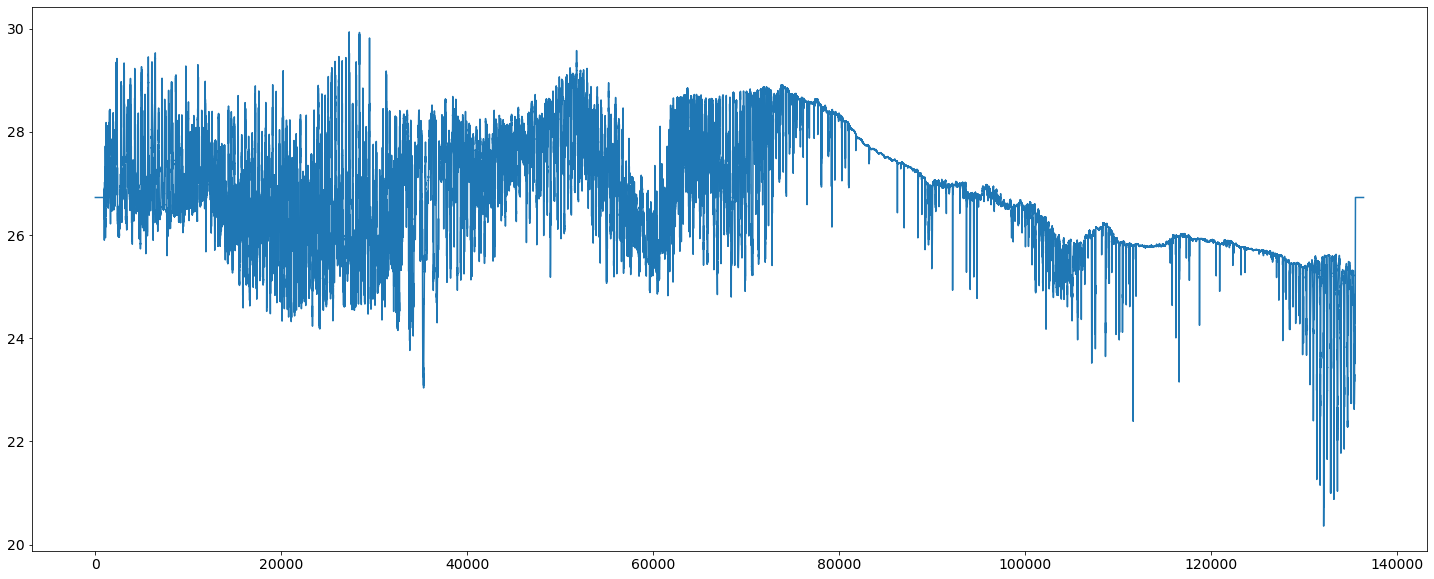

In [16]:
plt.plot(Temp_data_P1[0])

In [17]:
# Period 2
Time_P2, Depths_P2, Temp_data_P2, Temp_badidx_P2 = Processing.Collect_temp(KIM400_temp_ncfiles_P2)

Window_idx_List       =  Processing.Find_window_idx(Time_P2,window_days=window_days)
Time_P2_Window        =  Processing.Windowing(Time_P2,Window_idx_List )
Temp_data_P2_Window   =  Processing.Windowing(Temp_data_P2,Window_idx_List )
Temp_badidx_P2_Window =  Processing.Windowing(Temp_badidx_P2,Window_idx_List )

C:\Users\21924032\GitHub\Yutao_PhD_codes\Yutao Aim1 Internal Tide\notebooks\1D internal tide temp model fit V1.2\functions\Processing.py:181: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  data_window.append(data[idx])


In [18]:
# Period 3
Time_P3, Depths_P3, Temp_data_P3, Temp_badidx_P3 = Processing.Collect_temp(KIM400_temp_ncfiles_P3)

Window_idx_List       =  Processing.Find_window_idx(Time_P3,window_days=window_days)
Time_P3_Window        =  Processing.Windowing(Time_P3,Window_idx_List )
Temp_data_P3_Window   =  Processing.Windowing(Temp_data_P3,Window_idx_List )
Temp_badidx_P3_Window =  Processing.Windowing(Temp_badidx_P3,Window_idx_List )

C:\Users\21924032\GitHub\Yutao_PhD_codes\Yutao Aim1 Internal Tide\notebooks\1D internal tide temp model fit V1.2\functions\Processing.py:181: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  data_window.append(data[idx])


In [19]:
# Period 4
Time_P4, Depths_P4, Temp_data_P4, Temp_badidx_P4 = Processing.Collect_temp(KIM400_temp_ncfiles_P4)

Window_idx_List       =  Processing.Find_window_idx(Time_P4,window_days=window_days)
Time_P4_Window        =  Processing.Windowing(Time_P4,Window_idx_List )
Temp_data_P4_Window   =  Processing.Windowing(Temp_data_P4,Window_idx_List )
Temp_badidx_P4_Window =  Processing.Windowing(Temp_badidx_P4,Window_idx_List )

C:\Users\21924032\GitHub\Yutao_PhD_codes\Yutao Aim1 Internal Tide\notebooks\1D internal tide temp model fit V1.2\functions\Processing.py:181: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  data_window.append(data[idx])


In [20]:
# Period 5
Time_P5, Depths_P5, Temp_data_P5, Temp_badidx_P5 = Processing.Collect_temp(KIM400_temp_ncfiles_P5)

Window_idx_List       =  Processing.Find_window_idx(Time_P5,window_days=window_days)
Time_P5_Window        =  Processing.Windowing(Time_P5,Window_idx_List )
Temp_data_P5_Window   =  Processing.Windowing(Temp_data_P5,Window_idx_List )
Temp_badidx_P5_Window =  Processing.Windowing(Temp_badidx_P5,Window_idx_List )

C:\Users\21924032\GitHub\Yutao_PhD_codes\Yutao Aim1 Internal Tide\notebooks\1D internal tide temp model fit V1.2\functions\Processing.py:181: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  data_window.append(data[idx])


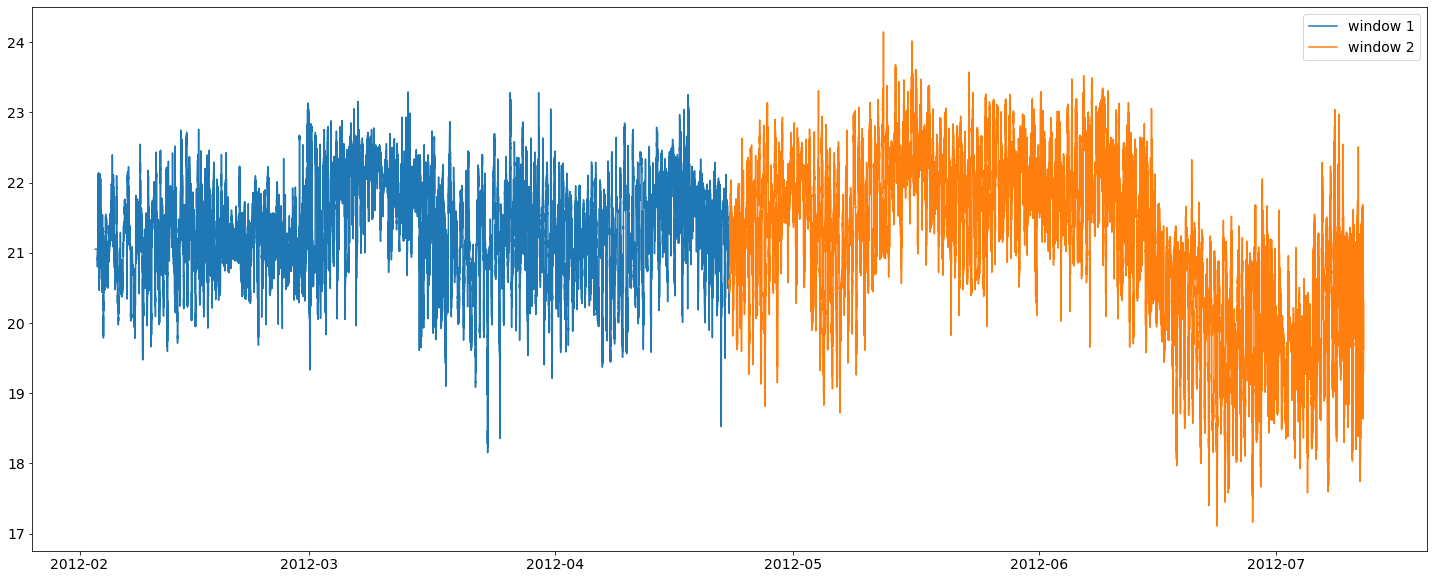

In [21]:
for i in range(len(Time_P1_Window[10])):
    plt.plot(Time_P1_Window[10][i],Temp_data_P1_Window[10][i],label='window {}'.format(i+1))
plt.legend()

In [22]:
year_list_P1,start_date_list_P1,end_date_list_P1 = Processing.Find_window_label(Time_P1_Window)
year_list_P2,start_date_list_P2,end_date_list_P2 = Processing.Find_window_label(Time_P2_Window)
year_list_P3,start_date_list_P3,end_date_list_P3 = Processing.Find_window_label(Time_P3_Window)
year_list_P4,start_date_list_P4,end_date_list_P4 = Processing.Find_window_label(Time_P4_Window)
year_list_P5,start_date_list_P5,end_date_list_P5 = Processing.Find_window_label(Time_P5_Window)

In [23]:
#set freq for low-pass filter
cutoff_freq = 10  # Cutoff frequency (in Hz)
nyquist_freq = (Time_P1[3][1]-Time_P1[3][0]).astype('float')/1e9  # Nyquist frequency

temp_avg_list_P1 = Processing.Find_mean_temp(Temp_data_P1_Window,cutoff_freq,nyquist_freq)
temp_avg_list_P2 = Processing.Find_mean_temp(Temp_data_P2_Window,cutoff_freq,nyquist_freq)
temp_avg_list_P3 = Processing.Find_mean_temp(Temp_data_P3_Window,cutoff_freq,nyquist_freq)
temp_avg_list_P4 = Processing.Find_mean_temp(Temp_data_P4_Window,cutoff_freq,nyquist_freq)
temp_avg_list_P5 = Processing.Find_mean_temp(Temp_data_P5_Window,cutoff_freq,nyquist_freq)

In [24]:
#remove mean
Temp_data_P1_Window_no_mean = Processing.Remove_mean(Temp_data_P1_Window)
Temp_data_P2_Window_no_mean = Processing.Remove_mean(Temp_data_P2_Window)
Temp_data_P3_Window_no_mean = Processing.Remove_mean(Temp_data_P3_Window)
Temp_data_P4_Window_no_mean = Processing.Remove_mean(Temp_data_P4_Window)
Temp_data_P5_Window_no_mean = Processing.Remove_mean(Temp_data_P5_Window)

#set freq for low-pass filter
cutoff_freq = 10  # Cutoff frequency (in Hz)
nyquist_freq = (Time_P1[3][1]-Time_P1[3][0]).astype('float')/1e9  # Nyquist frequency

temp_avg_list_P1_no_mean = Processing.Find_mean_temp(Temp_data_P1_Window_no_mean,cutoff_freq,nyquist_freq)
temp_avg_list_P2_no_mean = Processing.Find_mean_temp(Temp_data_P2_Window_no_mean,cutoff_freq,nyquist_freq)
temp_avg_list_P3_no_mean = Processing.Find_mean_temp(Temp_data_P3_Window_no_mean,cutoff_freq,nyquist_freq)
temp_avg_list_P4_no_mean = Processing.Find_mean_temp(Temp_data_P4_Window_no_mean,cutoff_freq,nyquist_freq)
temp_avg_list_P5_no_mean = Processing.Find_mean_temp(Temp_data_P5_Window_no_mean,cutoff_freq,nyquist_freq)

## Construct a pd dataframe

In [25]:
final_P1 = Processing.Create_df(start_date_list_P1,end_date_list_P1,year_list_P1,temp_avg_list_P1,temp_avg_list_P1_no_mean,Depths_P1)
final_P2 = Processing.Create_df(start_date_list_P2,end_date_list_P2,year_list_P2,temp_avg_list_P2,temp_avg_list_P2_no_mean,Depths_P2)
final_P3 = Processing.Create_df(start_date_list_P3,end_date_list_P3,year_list_P3,temp_avg_list_P3,temp_avg_list_P3_no_mean,Depths_P3)
final_P4 = Processing.Create_df(start_date_list_P4,end_date_list_P4,year_list_P4,temp_avg_list_P4,temp_avg_list_P4_no_mean,Depths_P4)
final_P5 = Processing.Create_df(start_date_list_P5,end_date_list_P5,year_list_P5,temp_avg_list_P5,temp_avg_list_P5_no_mean,Depths_P5)

final_df = pd.concat([final_P1, final_P2,final_P3,final_P4,final_P5])
# final_df

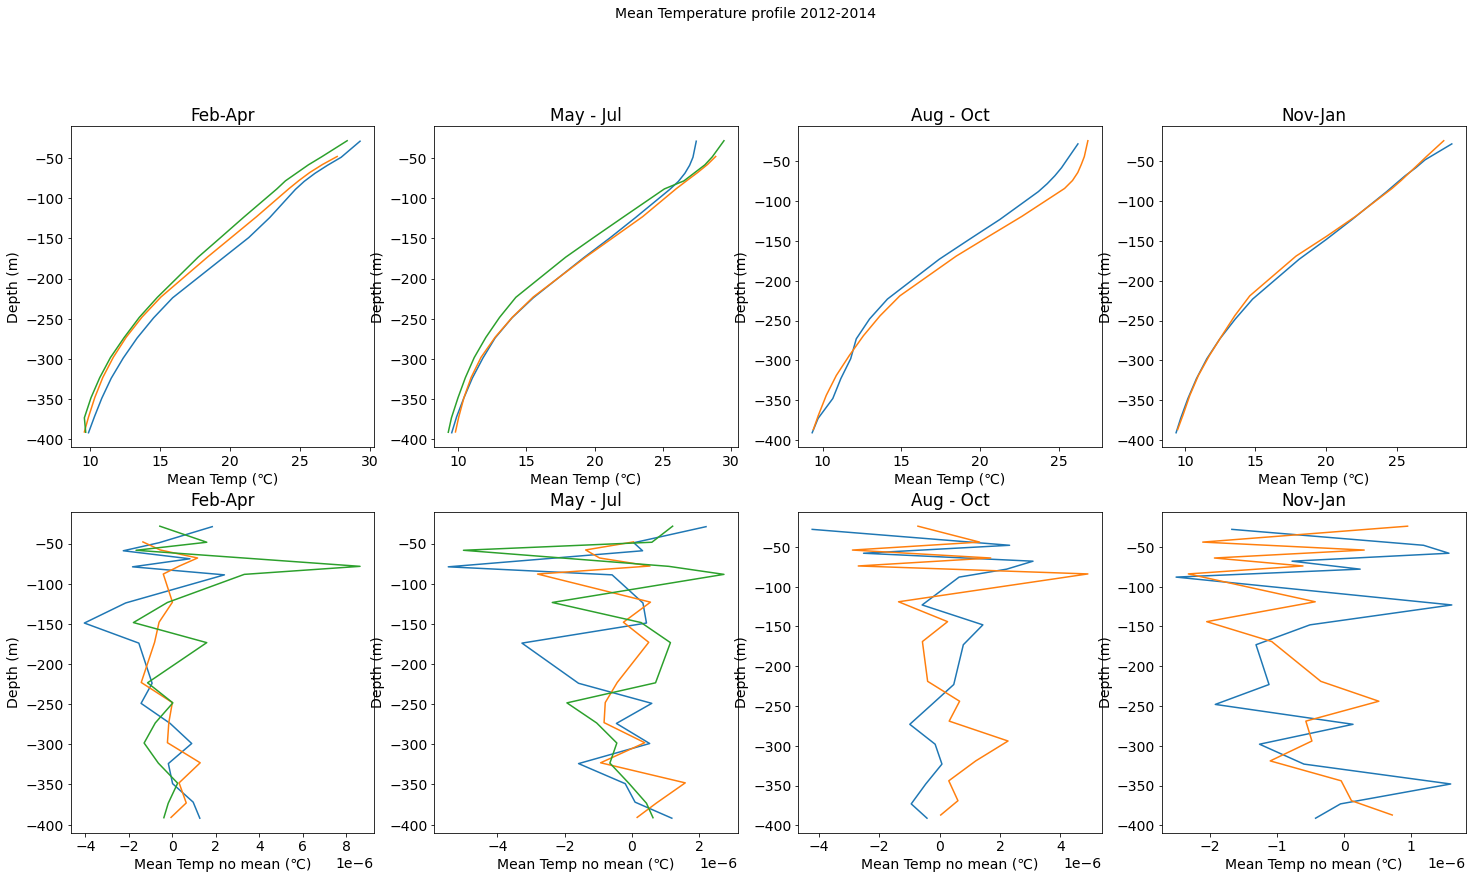

In [26]:
#plot mean
season = final_df['season'].drop_duplicates()
year = final_df['year'].drop_duplicates()
fig, axs = plt.subplots(2,4, figsize=(25, 13))
fig.text(0.5, 1, 'Mean Temperature profile 2012-2014', ha='center', va='center')    
for i in range(len(season)):   # 4season
    for ii in year:
        selected_df = final_df[(final_df['season']==season.iloc[i]) & (final_df['year']==ii)].sort_index()
        
        axs[0,i].plot(selected_df['mean_temp'],-selected_df.index,)
        axs[0,i].set_title(season.iloc[i])
        axs[0,i].set_ylabel('Depth (m)')
        axs[0,i].set_xlabel('Mean Temp (℃)')
        
        axs[1,i].plot(selected_df['mean_temp_no_mean'],-selected_df.index,)
        axs[1,i].set_title(season.iloc[i])
        axs[1,i].set_ylabel('Depth (m)')
        axs[1,i].set_xlabel('Mean Temp no mean (℃)')

# Using harmonic analysis as the mean function

In [27]:
from functions import Harmonics

$$
\begin{bmatrix}y_1\\y_2\\y_3\\...\\y_n\end{bmatrix}=\begin{bmatrix}\cos(2\pi*p_1x_1)&\cos(2\pi*p_2x_1)&\cos(2\pi*p_3x_1)&\cos(2\pi*p_4x_1)&sin(2\pi*p_1x_1)&\sin(2\pi*p_2*x_1)&\sin(2\pi*p_3x_1)&\sin(2\pi*p_4x_1)\\\cos(2\pi*p_1x_2)&\cos(2\pi*p_2x_2)&\cos(2\pi*p_3x_2)&sin(2\pi*p_1x_2)&\sin(2\pi*p_2*x_2)&\sin(2\pi*p_3x_2)&\cos(2\pi*p_4x_2)&\sin(2\pi*p_4x_2)\\\cos(2\pi*p_1x_3)&sin(2\pi*p_1x_3)&\cos(2\pi*p_2x_3)&\sin(2\pi*p_2*x_3)&\cos(2\pi*p_3x_3)&\sin(2\pi*p_3x_3)&\cos(2\pi*p_4x_3)&\sin(2\pi*p_4x_3)\\...\\\cos(2\pi*p_1x_n)&sin(2\pi*p_1x_n)&\cos(2\pi*p_2x_n)&\sin(2\pi*p_2*x_n)&\cos(2\pi*p_3x_n)&\sin(2\pi*p_3x_n)&\cos(2\pi*p_4x_n)&\sin(2\pi*p_4x_n)\end{bmatrix}\begin{bmatrix}a_1\\a_2\\a_3\\a_4\\b_1\\b_2\\b_3\\b_4\end{bmatrix}+\epsilon
$$ 

$$
 \underline{y}=X \underline{\beta}+ \underline{\epsilon}
$$

From Gauss–Markov theorem:
$$
	\hat{\beta}=(X^TX)^{-1}X^Ty
$$

In [28]:
# total depth is ~400m
interest_depth = 89
idx = Depths_P1.index(interest_depth)
y = Temp_data_P1_Window[idx][0] #remove the depth avg velocity
obs_time = Time_P1_Window[idx][0]
obs_sample_interval = (obs_time[1]- obs_time [0]).astype(float)/1e9                #second
obs_sample_interval_days = obs_sample_interval/86400 # second to day 

N = len(y)
time_length = len(y)
x  = np.linspace(0,obs_sample_interval_days*N,N)#[:,None]
Xd = Harmonics.Mean_X(x)
mean_params = Harmonics.OLS(Xd,y)
yd_mean = Harmonics.Prior_mean_function(x,mean_params)
ϵ =  y - yd_mean #residual

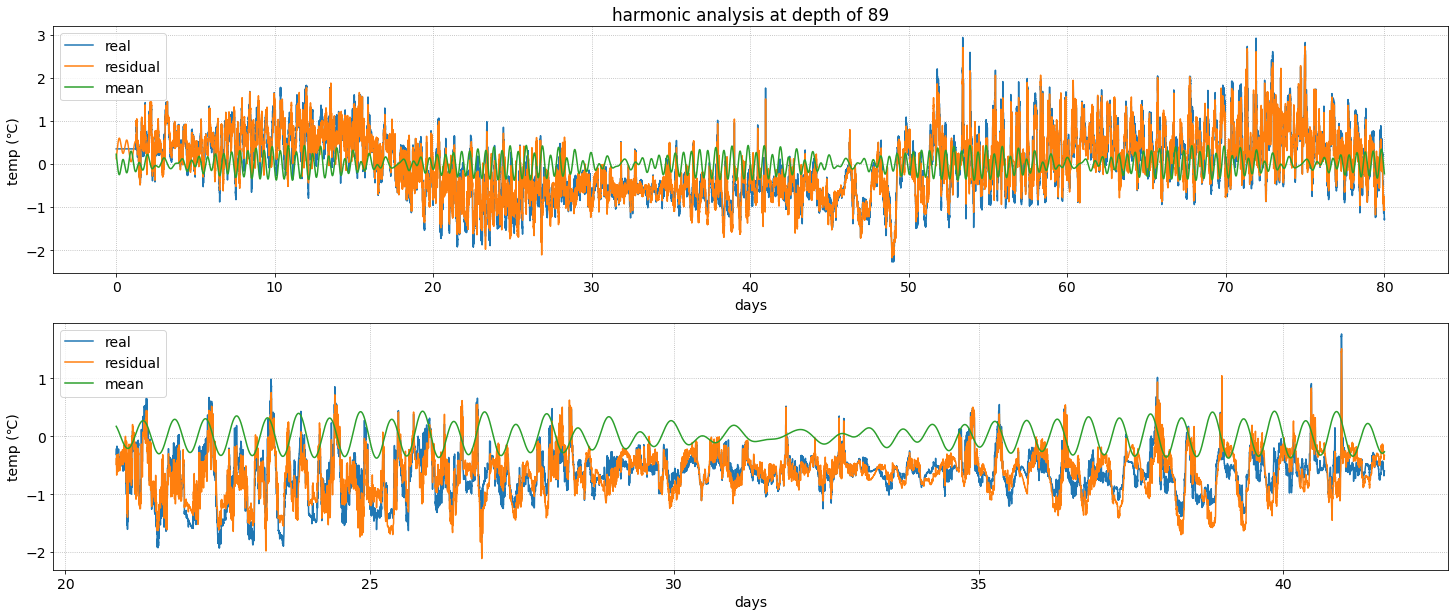

In [29]:
plt.subplot(2, 1, 1)
plt.plot(x,y,label='real')
plt.plot(x,ϵ,label = 'residual')
plt.plot(x,yd_mean,label='mean')
plt.legend()
plt.xlabel('days')
plt.ylabel('temp (℃)')
plt.grid(b=True,ls=':')
plt.title('harmonic analysis at depth of {}'.format(interest_depth))

plt.subplot(2, 1, 2)
idx = 60000
plt.plot(x[30000:idx],y[30000:idx],label='real')
plt.plot(x[30000:idx],ϵ[30000:idx],label = 'residual')
plt.plot(x[30000:idx],yd_mean[30000:idx],label='mean')
plt.legend()

plt.xlabel('days')
plt.ylabel('temp (℃)')
plt.grid(b=True,ls=':')

(1e-09, 10.0)

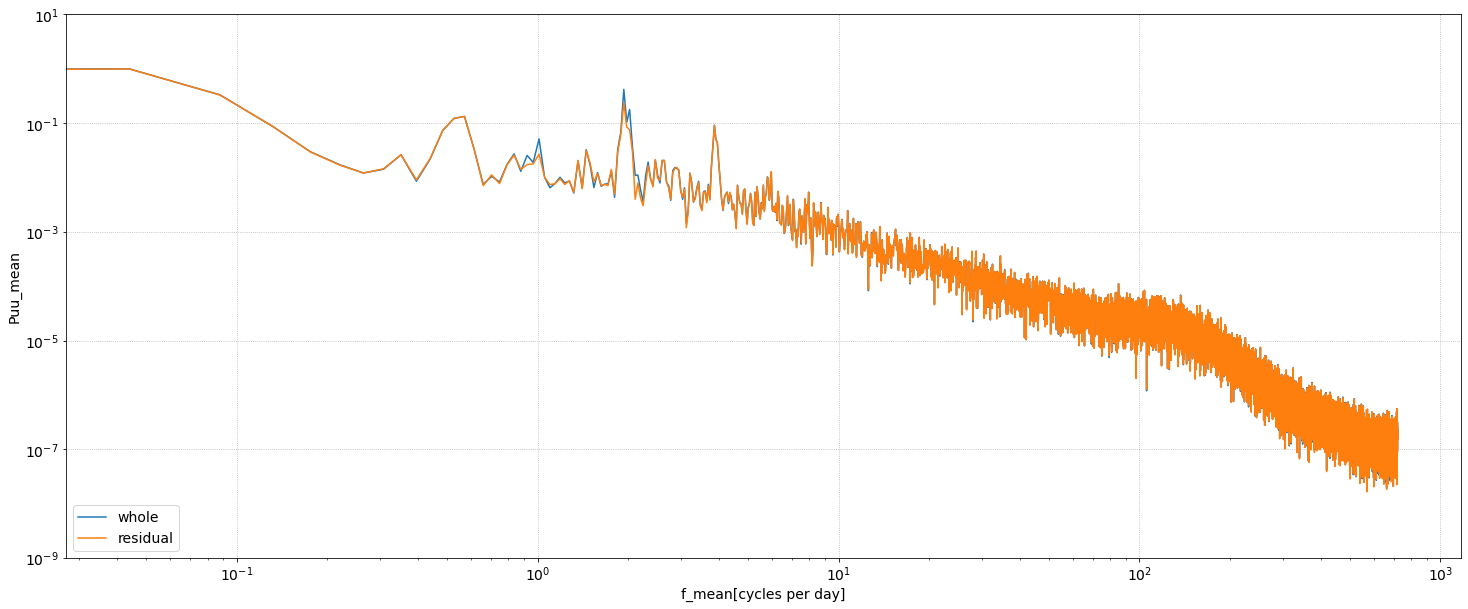

In [30]:
f_mean, Puu_mean= Processing.Welch(yd_mean,obs_sample_interval_days)
f_ϵ,Puu_ϵ= Processing.Welch(ϵ,obs_sample_interval_days)
f_obs_w,pvv_obs_w = Processing.Welch(y,obs_sample_interval_days)

# f_mean, Puu_mean= processing.periodogram(yd_mean,obs_sample_interval_days)
# f_ϵ,Puu_ϵ= processing.periodogram(ϵ,obs_sample_interval_days)
# f_obs_w,pvv_obs_w = processing.periodogram(y,obs_sample_interval_days)

# plt.plot(f_mean, Puu_mean,label='mean',lw=2)
plt.plot(f_obs_w,pvv_obs_w,label='whole')
plt.plot(f_ϵ,Puu_ϵ,label='residual')

plt.xscale("log")
plt.yscale("log")

plt.xlabel('f_mean[cycles per day]')
plt.ylabel('Puu_mean')
plt.grid(b=True,ls=':')
plt.legend(loc="lower left")

# plt.xlim(0.1,5)
plt.ylim(1e-9, 1e1)

In [31]:
# remove mean is added into the cal_harmonics_spectrum_depth_profile function
Mean_params_P1, F_p_P1, P_p_P1_raw, F_w_P1,P_w_P1_raw = Harmonics.Cal_harmonics_spectrum_depth_profile(Time_P1_Window,Depths_P1,Temp_data_P1_Window_no_mean )
Mean_params_P2, F_p_P2, P_p_P2_raw, F_w_P2,P_w_P2_raw = Harmonics.Cal_harmonics_spectrum_depth_profile(Time_P2_Window,Depths_P2,Temp_data_P2_Window_no_mean )
Mean_params_P3, F_p_P3, P_p_P3_raw, F_w_P3,P_w_P3_raw = Harmonics.Cal_harmonics_spectrum_depth_profile(Time_P3_Window,Depths_P3,Temp_data_P3_Window_no_mean )
Mean_params_P4, F_p_P4, P_p_P4_raw, F_w_P4,P_w_P4_raw = Harmonics.Cal_harmonics_spectrum_depth_profile(Time_P4_Window,Depths_P4,Temp_data_P4_Window_no_mean )
Mean_params_P5, F_p_P5, P_p_P5_raw, F_w_P5,P_w_P5_raw = Harmonics.Cal_harmonics_spectrum_depth_profile(Time_P5_Window,Depths_P5,Temp_data_P5_Window_no_mean )

C:\Users\21924032\Anaconda3\lib\site-packages\scipy\signal\spectral.py:1964: UserWarning: nperseg = 32768 is greater than input length  = 23041, using nperseg = 23041
  warnings.warn('nperseg = {0:d} is greater than input length '


(1e-07, 10)

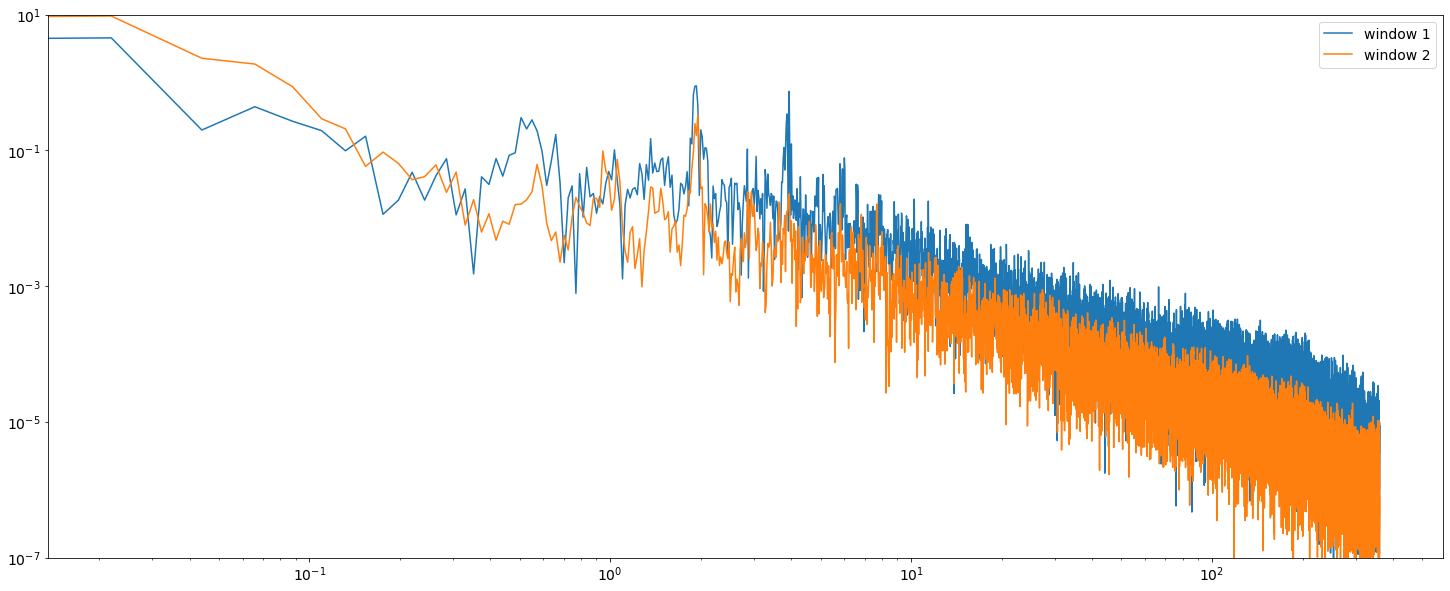

In [32]:
for i in range(len(F_w_P1[0])):
    plt.loglog(F_w_P1[0][i],P_w_P1_raw[0][i],label='window {}'.format(i+1))
plt.legend()
plt.ylim(1e-7,10)

## Scaling the periodogram similar to Parzen1996

In [33]:
P_p_P1 = Processing.Scale_periodogram(P_p_P1_raw,Temp_badidx_P1_Window)
P_p_P2 = Processing.Scale_periodogram(P_p_P2_raw,Temp_badidx_P2_Window)
P_p_P3 = Processing.Scale_periodogram(P_p_P3_raw,Temp_badidx_P3_Window)
P_p_P4 = Processing.Scale_periodogram(P_p_P4_raw,Temp_badidx_P4_Window)
P_p_P5 = Processing.Scale_periodogram(P_p_P5_raw,Temp_badidx_P5_Window)

In [34]:
P_w_P1 = Processing.Scale_periodogram(P_w_P1_raw,Temp_badidx_P1_Window)
P_w_P2 = Processing.Scale_periodogram(P_w_P2_raw,Temp_badidx_P2_Window)
P_w_P3 = Processing.Scale_periodogram(P_w_P3_raw,Temp_badidx_P3_Window)
P_w_P4 = Processing.Scale_periodogram(P_w_P4_raw,Temp_badidx_P4_Window)
P_w_P5 = Processing.Scale_periodogram(P_w_P5_raw,Temp_badidx_P5_Window)

Text(0.5, 1.0, 'Comparisoon of Raw and Scalled periodogram at 89m')

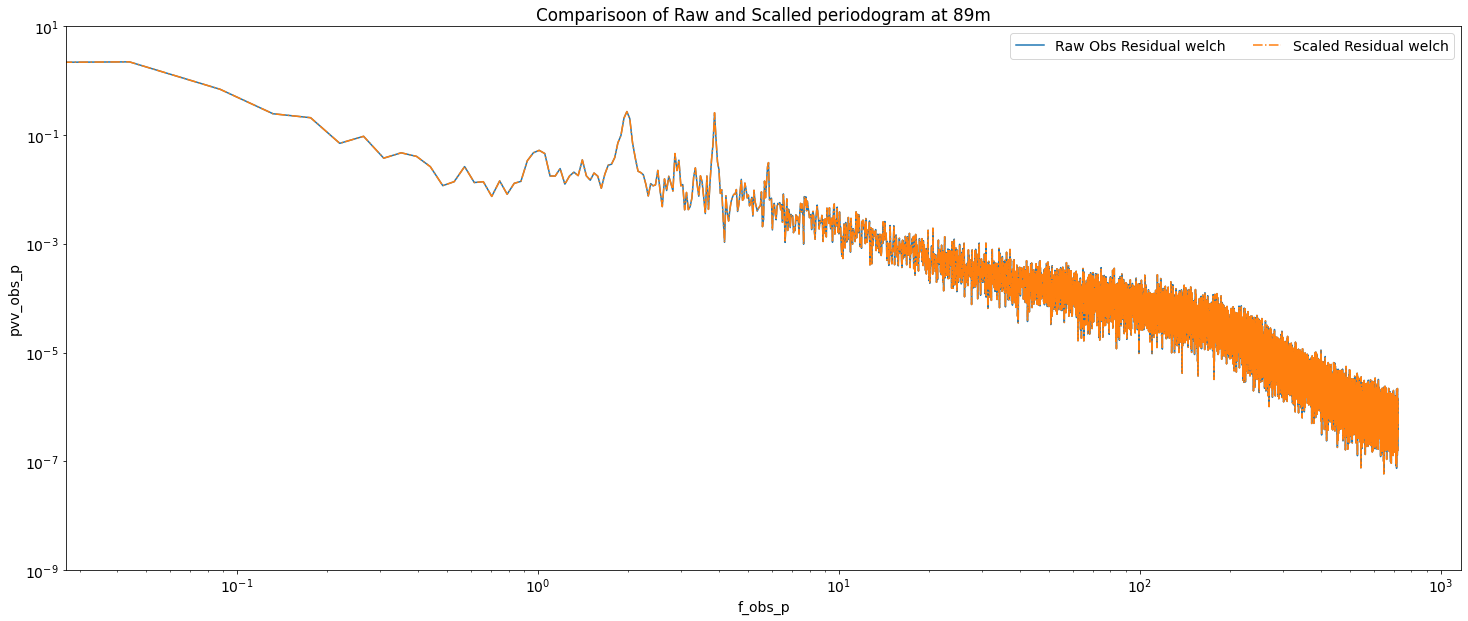

In [35]:
interest_depth = 89
idx = Depths_P1.index(interest_depth)
# plt.plot(F_residual_p[idx],P_residual_p_raw[idx],'-',label='Raw Obs Residual')
# plt.plot(F_residual_p[idx],P_residual_p[idx],'-.',label='Scaled Residual Periodogram')

plt.plot(F_w_P1[idx][1],P_w_P1_raw[idx][1],'-',label='Raw Obs Residual welch')
plt.plot(F_w_P1[idx][1],P_w_P1[idx][1],'-.',label='Scaled Residual welch')

# for j in range(len(xcoords)):
#     plt.axvline(x=xcoords[j],linestyle='--', color=xcoords_color[j], label=xcoords_label[j])
plt.ylim(1e-9, 1e1)
plt.legend(ncol=3)
#     plt.xlim(0.1, 10)
plt.ylabel('pvv_obs_p')
plt.xlabel('f_obs_p')
plt.xscale("log")
plt.yscale("log")
plt.title('Comparisoon of Raw and Scalled periodogram at {}m'.format(interest_depth))

Therefore, the following analysis will be conducted from depth of 30m towards the seabed.

# Specify the horizontal domain, bathymetry section and vertical density profile

In [36]:
from functions import Bathmetry

In [37]:
#bathy_params = [H, h0, x0, lt]  # See the depth_tanh function for the mean

# bathy_params = [600, 450, 75e3, 70e3]  #set 1
#bathy_params = [300, 200,75e3,70e3] #set 2
bathy_params = [400,200,75e3, 70e3] #set 3

N = 16000  # Number of grid points
dx = 25.  # horizontal grid spacing

# The horizontal domain
x = np.arange(0, N * dx, dx)

# The depth
h = Bathmetry.Depth_tanh(bathy_params, x)

In [38]:
# See the references above for the mean of the,
#set 1
rho_params =[1025.66780468, # Mean density,             beta0
     1.5, # Density jump,                        beta1
     150,# Depth of the second pycnocline      beta4
     50, # Width of the second pycnocline     beta5
        ]
# Number of vertical levels
Nz = 40
#z = np.linspace(-H,0,Nz)
# z = np.linspace(-bathy_params[0],0,Nz) #bathy_params[0]=H
z = np.arange(-400,1,10)
# rhoz = rho_double_tanh(rho_params,z)
rhoz = Bathmetry.Single_tanh(z,rho_params)
# rhoz = constant_N(rho_params,z)

Text(0.5, 1.0, 'Stratification')

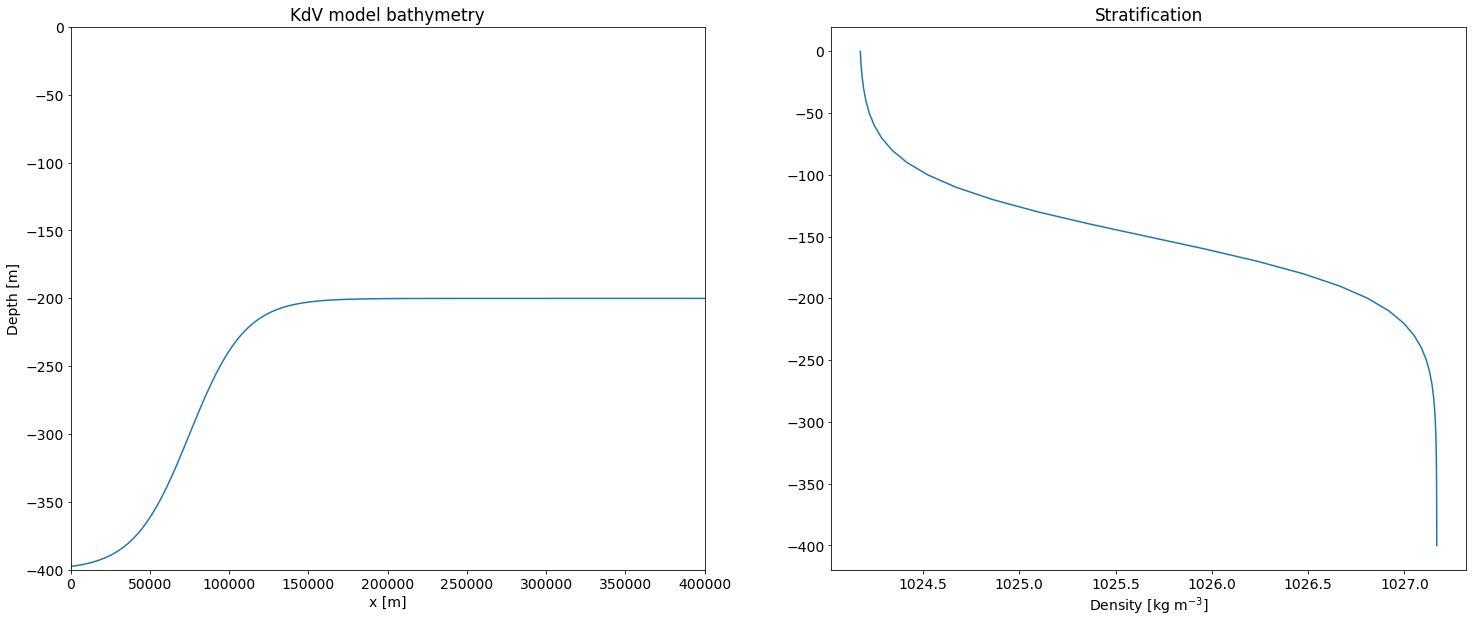

In [39]:
fig, (ax1, ax2) = plt.subplots(1, 2)
ax1.plot(x, -h)  #negative bc depth
ax1.set_title('KdV model bathymetry')
ax1.set_ylabel('Depth [m]')
ax1.set_xlabel('x [m]')
#plt.ylim(-H, 0)
ax1.set_ylim(-bathy_params[0], 0)
ax1.set_xlim(0, dx * N)

ax2.plot(rhoz, z)
# plt.xticks(np.arange(min(rhoz), max(rhoz), 0.5))
# ax2.set_ylabel('Depth [m]')
ax2.set_xlabel('Density [kg m$^{-3}$]')
ax2.set_title('Stratification')
# ax2.xaxis.tick_top()

## From the vertical density profile to find the vertical structure

(array([0.        , 0.07687536, 0.15373435, 0.23054468, 0.30724678,
        0.38373557, 0.45983197, 0.53524007, 0.60948584, 0.681836  ,
        0.75120433, 0.81607009, 0.87446053, 0.92407239, 0.9625925 ,
        0.98818855, 1.        , 0.99838514, 0.98478656, 0.96130184,
        0.93018943, 0.89350164, 0.85290635, 0.80965839, 0.76465216,
        0.71850136, 0.67161585, 0.62426405, 0.57661921, 0.52879187,
        0.4808519 , 0.43284309, 0.38479268, 0.33671745, 0.28862765,
        0.24052946, 0.1924266 , 0.14432123, 0.09621459, 0.04810739,
        0.        ]),
 1.4287273869388653,
 210.49639758034343,
 array([   0.,  -10.,  -20.,  -30.,  -40.,  -50.,  -60.,  -70.,  -80.,
         -90., -100., -110., -120., -130., -140., -150., -160., -170.,
        -180., -190., -200., -210., -220., -230., -240., -250., -260.,
        -270., -280., -290., -300., -310., -320., -330., -340., -350.,
        -360., -370., -380., -390., -400.]))

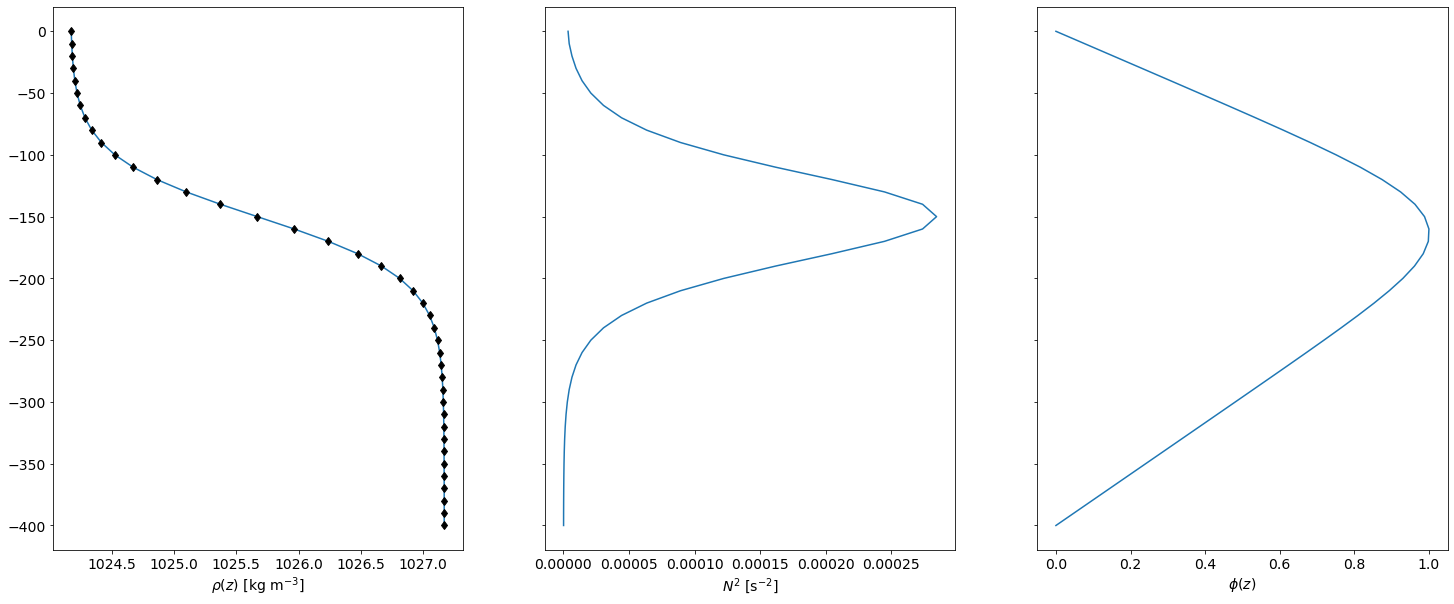

In [40]:
import iwaves
WaveModes = iwaves.IWaveModes(rhoz,z,density_func='single_tanh_rho')
zmax = -np.max(np.abs(z))
dz = z[1]-z[0]
phi_1, c1, h_e, Z = WaveModes(zmax,dz,mode=0)  # mode 1
iwaves.IWaveModes.plot_modes(WaveModes)
phi_1, c1, h_e,Z

In [41]:
phi_depth_profile = xr.DataArray(phi_1, coords={'depth': Z}, dims=['depth'])

## Garret-Munk Spectral Model

In [42]:
# Garret-Munk 
from functions import GM81 as gm
# Coriolis frequency
f = f_coriolis_cpd/86400 #hz
# buoyancy frequency (corresponding to 1000 m depth)
buoyancy_freq = 200
N = buoyancy_freq/86400  #hz
# surface-extrapolated buoyancy frequency
N0 = np.sqrt(WaveModes.N2)[0] #hz
# e-folding scale of N(z) # how long N(z) take to increase by e
b = 35000#m
# frequency
omg = np.linspace(1.01*f, N, len(F_p_P1[0][0]))
# mode number
j = np.arange(1, 100)
# reshape to allow multiplication into 2D array
Omg = np.reshape(omg, (omg.size,1))
J = np.reshape(j, (1,j.size))
# frequency spectra (KE and PE)
K_omg_j = gm.K_omg_j(Omg, J, f, N, N0, b)
P_omg_j = gm.P_omg_j(Omg, J, f, N, N0, b)
# sum over modes
K_omg = np.sum(K_omg_j, axis=1)
P_omg = np.sum(P_omg_j, axis=1)
GM_spectrum = P_omg  #(m^2/s^2/cps)
P_omg

array([4.71125913e+03, 6.92314658e+03, 8.37158076e+03, ...,
       2.36034831e-01, 2.36018483e-01, 2.36002136e-01])

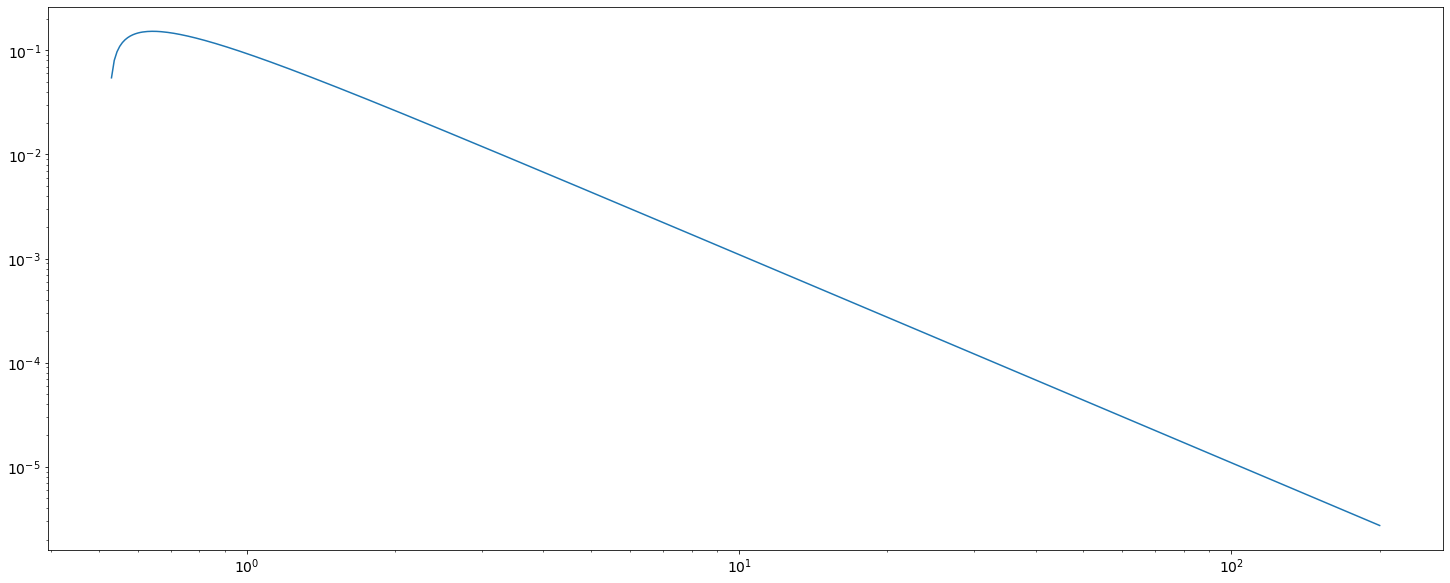

In [43]:
plt.loglog(omg*86400,GM_spectrum/86400,label = 'GM81')

# Optimizing params for the residual function -- Whittle likelihood

Fitting in frequency domain using Whittle likelihood

$$
ℓ_W(\theta) = -\sum\limits _{\omega\in\Omega}\begin{Bmatrix}\log\hat{f}(\omega;\theta)+\frac{I(\omega)}{\hat{f}(\omega;\theta)}\end{Bmatrix}  
$$

where $\hat{f}(\omega;\theta)$ is the continuous-time process spectral density (what we expected)  and $I(\omega)$ is the periodogram (what we observed)

In [44]:
f_coriolis_cpd

0.5250941365946958

# Workflow on the Residual

Parametric 

In [45]:
from functions import Cov
from functions import Optimisation

## Define the boundary and initial guess

In [46]:
#Initia guess
IG_noise = 1.5e-5

IG_η_matern = 0.5
IG_α_matern = 1 #impact the slope

IG_eta = 0.5
IG_ℓ_exp = 5 #impact how wide the brodening of peak 1 is (proportional)  

In [47]:
##bounds
bound_noise = [0,1]

bound_η_matern = [0.001,10]
bound_α_matern = [0.01,2.5] #impact the slope                  # from matern 7/2 to matern 1/2 to matern 0

# K1_freq,O1_freq,M2_freq,S2_freq
bound_eta = [0.01,10]     # K1 peak

bound_ℓ_exp = [0.01,15]  #impact how wide the brodening of peak 1 is (reverse proportional)  peak 1 is designed to be broader than peak 2

## Select Frequency range to omit the influence of inertial and M4 peak 

Generally, the Whittle likelihood is applied to optimize the parameters for the whole frequency band of the observed periodogram (an estimation of the true spectrum). However, in our case, we selected a range of frequencies (from coriolis frequency to buoyancy frequency) to perform the optimization because the internal tide behaviors appear in this bandwidth. In addition, since the inertial and M4 peak are not the characteristics of the internal tides, they are omitted in our optimization using Whittle likelihood.

In [48]:
subset_p_P1 = Processing.Subset_IT(F_p_P1,f_coriolis_cpd)
subset_w_P1 = Processing.Subset_IT(F_w_P1,f_coriolis_cpd)

subset_p_P2 = Processing.Subset_IT(F_p_P2,f_coriolis_cpd)
subset_w_P2 = Processing.Subset_IT(F_w_P2,f_coriolis_cpd)

subset_p_P3 = Processing.Subset_IT(F_p_P3,f_coriolis_cpd)
subset_w_P3 = Processing.Subset_IT(F_w_P3,f_coriolis_cpd)

subset_p_P4 = Processing.Subset_IT(F_p_P4,f_coriolis_cpd)
subset_w_P4 = Processing.Subset_IT(F_w_P4,f_coriolis_cpd)

subset_p_P5 = Processing.Subset_IT(F_p_P5,f_coriolis_cpd)
subset_w_P5 = Processing.Subset_IT(F_w_P5,f_coriolis_cpd)

In [49]:
F_p_P1_modulated = Processing.Select_frequency(F_p_P1,subset_p_P1)
P_p_P1_modulated = Processing.Select_frequency(P_p_P1,subset_p_P1)

F_p_P2_modulated = Processing.Select_frequency(F_p_P2,subset_p_P2)
P_p_P2_modulated = Processing.Select_frequency(P_p_P2,subset_p_P2) 

F_p_P3_modulated = Processing.Select_frequency(F_p_P3,subset_p_P3)
P_p_P3_modulated = Processing.Select_frequency(P_p_P3,subset_p_P3) 

F_p_P4_modulated = Processing.Select_frequency(F_p_P4,subset_p_P4) 
P_p_P4_modulated = Processing.Select_frequency(P_p_P4,subset_p_P4)

F_p_P5_modulated = Processing.Select_frequency(F_p_P5,subset_p_P5) 
P_p_P5_modulated = Processing.Select_frequency(P_p_P5,subset_p_P5) 

Text(0.5, 1.0, 'Comparison of temp residual spectrum at 89m')

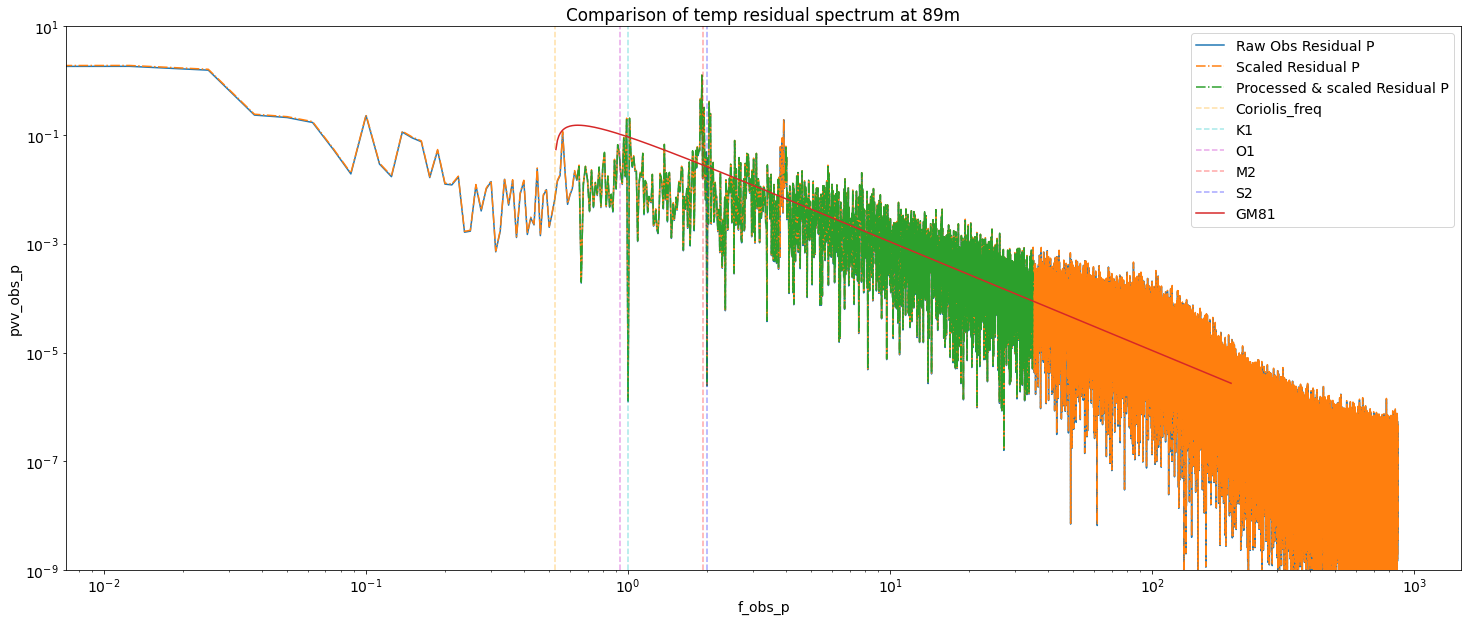

In [50]:
# # total depth is ~400m
interest_depth = 89
idx = Depths_P1.index(interest_depth)
# y = Temp_profile.temperature.sel(depth=depth_below_surface[idx]) #remove the depth avg velocity

plt.plot(F_p_P3[idx][0],P_p_P3_raw[idx][0],label='Raw Obs Residual P')
plt.plot(F_p_P3[idx][0],P_p_P3[idx][0],'-.',label='Scaled Residual P')
plt.plot(F_p_P3_modulated[idx][0],P_p_P3_modulated[idx][0],'-.',label='Processed & scaled Residual P')

for j in range(len(xcoords)):
    plt.axvline(x=xcoords[j],linestyle='--', color=xcoords_color[j], label=xcoords_label[j],alpha=0.35)

# plt.plot(F_residual_w[idx],P_residual_w_raw[idx],label='Raw Obs Residual W')
# plt.plot(F_residual_w[idx],P_residual_w[idx],'-.',label='Scaled Residual W')
# plt.plot(F_residual_w_Modulated[idx],P_residual_w_Modulated[idx],'-.',label='Processed & scaled Residual W')
plt.plot(omg*86400,GM_spectrum/86400,label = 'GM81')
plt.legend()
plt.ylim(1e-9, 1e1)
# plt.xlim(0, 5)
plt.ylabel('pvv_obs_p')
plt.xlabel('f_obs_p')
plt.xscale("log")
plt.yscale("log")
plt.title('Comparison of temp residual spectrum at {}m'.format(interest_depth))

## M1L2 Kernal

In [51]:
def M1L2(dx,params):
    
    noise_var = params[0]
    η_matern1 = params[1]
    α_matern1 = params[2]
    eta1      = params[3]
    ℓ_exp1    = params[4]
    eta2      = params[5]
    ℓ_exp2    = params[6]
    
    matern1 = Cov.Matern(dx, (η_matern1,α_matern1),lmbda=20,sigma=1e-6)              #background energy continuum  
    peak1 = Cov.LR(dx,(eta1,ℓ_exp1),l_cos=1/((O1_freq+K1_freq)/2))
    peak2 = Cov.LR(dx,(eta2,ℓ_exp2),l_cos=1/((S2_freq+N2_freq)/2))
    noise = Cov.white_noise(dx,noise_var)
    COV = matern1 + peak1 + peak2 + noise
    return COV

In [52]:
def M1L2_no_noise(dx,params):
    
#     noise_var = params[0]
    η_matern1 = params[0]
    α_matern1 = params[1]
    eta1      = params[2]
    ℓ_exp1    = params[3]
    eta2      = params[4]
    ℓ_exp2    = params[5]
    
    matern1 = Cov.Matern(dx, (η_matern1,α_matern1),lmbda=20,sigma=1e-6)              #background energy continuum  
    peak1 = Cov.LR(dx,(eta1,ℓ_exp1),l_cos=1/((O1_freq+K1_freq)/2))
    peak2 = Cov.LR(dx,(eta2,ℓ_exp2),l_cos=1/((S2_freq+N2_freq)/2))
    COV = matern1 + peak1 + peak2 #+ noise
    return COV

In [53]:
#Initia guess
M1L2_covparams_ic = [ 
#                     IG_noise,
                    IG_η_matern,
                    IG_α_matern,
                    IG_eta,
                    IG_ℓ_exp,         
                    IG_eta,
                    IG_ℓ_exp,
                     ]#Semi-Diurnal frequency
#Boundary
M1L2_bounds_parameter = [
#     bound_noise,
                    bound_η_matern,
                    bound_α_matern,
                    bound_eta,
                    bound_ℓ_exp,
                    bound_eta,
                    bound_ℓ_exp,                     
]#Semi-Diurnal frequency

M1L2_parameter_name = [
#     'noise',
                    'η_matern1',
                    'α_matern1',
                     'eta1',
                    'ℓ_exp1',
                    'eta2',
                    'ℓ_exp2', ]

In [54]:
# #normalise the whittle parameter
# whittle_parameter_1 = whittle_parameter_1 * (len(F_analytical_result_2[0])/len(F_analytical_result_1[0])) # N_small/N_big

Run Model/

In [55]:
F_model_fit_list_P1_M1L2, P_model_fit_list_P1_M1L2, Soln_model_fit_list_P1_M1L2, Whittle_list_P1_M1L2 = Optimisation.Model_fit(P_p_P1, Time_P1_Window, subset_p_P1,
                                                                                                           M1L2_covparams_ic,M1L2_bounds_parameter,
                                                                                                           M1L2_no_noise)

C:\Users\21924032\GitHub\Yutao_PhD_codes\Yutao Aim1 Internal Tide\notebooks\1D internal tide temp model fit V1.2\functions\Cov.py:114: RuntimeWarning: invalid value encountered in multiply
  K *= K_nu(nu, np.abs(lmbda * dx))


In [56]:
F_model_fit_list_P2_M1L2, P_model_fit_list_P2_M1L2, Soln_model_fit_list_P2_M1L2, Whittle_list_P2_M1L2 = Optimisation.Model_fit(P_p_P2, Time_P2_Window, subset_p_P2,
                                                                             M1L2_covparams_ic,M1L2_bounds_parameter,
                                                                             M1L2_no_noise)

C:\Users\21924032\GitHub\Yutao_PhD_codes\Yutao Aim1 Internal Tide\notebooks\1D internal tide temp model fit V1.2\functions\Cov.py:113: RuntimeWarning: divide by zero encountered in power
  K *= np.power(np.abs(lmbda * dx), nu)
C:\Users\21924032\GitHub\Yutao_PhD_codes\Yutao Aim1 Internal Tide\notebooks\1D internal tide temp model fit V1.2\functions\Optimisation.py:34: RuntimeWarning: invalid value encountered in log
  whittle = -np.sum(np.log(P_hat) + I_ω_subset/P_hat)


In [57]:
F_model_fit_list_P3_M1L2, P_model_fit_list_P3_M1L2, Soln_model_fit_list_P3_M1L2, Whittle_list_P3_M1L2 = Optimisation.Model_fit(P_p_P3, Time_P3_Window, subset_p_P3,
                                                                             M1L2_covparams_ic,M1L2_bounds_parameter,
                                                                             M1L2_no_noise)

In [58]:
F_model_fit_list_P4_M1L2, P_model_fit_list_P4_M1L2, Soln_model_fit_list_P4_M1L2, Whittle_list_P4_M1L2 = Optimisation.Model_fit(P_p_P4, Time_P4_Window, subset_p_P4,
                                                                             M1L2_covparams_ic,M1L2_bounds_parameter,
                                                                             M1L2_no_noise)

not converging at depth idx of 3 and window 1


In [59]:
F_model_fit_list_P5_M1L2, P_model_fit_list_P5_M1L2, Soln_model_fit_list_P5_M1L2, Whittle_list_P5_M1L2 = Optimisation.Model_fit(P_p_P5, Time_P5_Window, subset_p_P5,
                                                                             M1L2_covparams_ic,M1L2_bounds_parameter,
                                                                             M1L2_no_noise)

## M1L1

In [60]:
def M1L1_no_noise(dx,params):
    
    η_matern1 = params[0]
    α_matern1 = params[1]
    eta2      = params[2]
    ℓ_exp2    = params[3]
    
    matern1 = Cov.Matern(dx, (η_matern1,α_matern1),lmbda=20,sigma=1e-6)              #background energy continuum  
    peak2 = Cov.LR(dx,(eta2,ℓ_exp2),l_cos=1/((S2_freq+N2_freq)/2))
    COV = matern1 + peak2
    return COV

In [61]:
#Initia guess
M1L1_covparams_ic = [ 
#                     IG_noise,
                    IG_η_matern,
                    IG_α_matern,
                    IG_eta,
                    IG_ℓ_exp,         
                     ]#Semi-Diurnal frequency
#Boundary
M1L1_bounds_parameter = [
#     bound_noise,
                    bound_η_matern,
                    bound_α_matern,
                    bound_eta,
                    bound_ℓ_exp,                
]#Semi-Diurnal frequency

M1L1_parameter_name = [
#     'noise',
                    'η_matern1',
                    'α_matern1',
                    'eta2',
                    'ℓ_exp2', ]

Run M1L1 kernel

In [62]:
F_model_fit_list_P1_M1L1, P_model_fit_list_P1_M1L1, Soln_model_fit_list_P1_M1L1, Whittle_list_P1_M1L1 = Optimisation.Model_fit(P_p_P1, Time_P1_Window, subset_p_P1,
                                                                                                                               M1L1_covparams_ic,M1L1_bounds_parameter,
                                                                                                                               M1L1_no_noise)

In [63]:
F_model_fit_list_P2_M1L1, P_model_fit_list_P2_M1L1, Soln_model_fit_list_P2_M1L1, Whittle_list_P2_M1L1 = Optimisation.Model_fit(P_p_P2, Time_P2_Window, subset_p_P2,
                                                                                                                               M1L1_covparams_ic,M1L1_bounds_parameter,
                                                                                                                               M1L1_no_noise)

In [64]:
F_model_fit_list_P3_M1L1, P_model_fit_list_P3_M1L1, Soln_model_fit_list_P3_M1L1, Whittle_list_P3_M1L1 = Optimisation.Model_fit(P_p_P3, Time_P3_Window, subset_p_P3,
                                                                                                                               M1L1_covparams_ic,M1L1_bounds_parameter,
                                                                                                                               M1L1_no_noise)

In [65]:
F_model_fit_list_P4_M1L1, P_model_fit_list_P4_M1L1, Soln_model_fit_list_P4_M1L1, Whittle_list_P4_M1L1 = Optimisation.Model_fit(P_p_P4, Time_P4_Window, subset_p_P4,
                                                                                                                               M1L1_covparams_ic,M1L1_bounds_parameter,
                                                                                                                               M1L1_no_noise)

In [66]:
F_model_fit_list_P5_M1L1, P_model_fit_list_P5_M1L1, Soln_model_fit_list_P5_M1L1, Whittle_list_P5_M1L1 = Optimisation.Model_fit(P_p_P5, Time_P5_Window, subset_p_P5,
                                                                                                                               M1L1_covparams_ic,M1L1_bounds_parameter,
                                                                                                                               M1L1_no_noise)

## Model fit results 

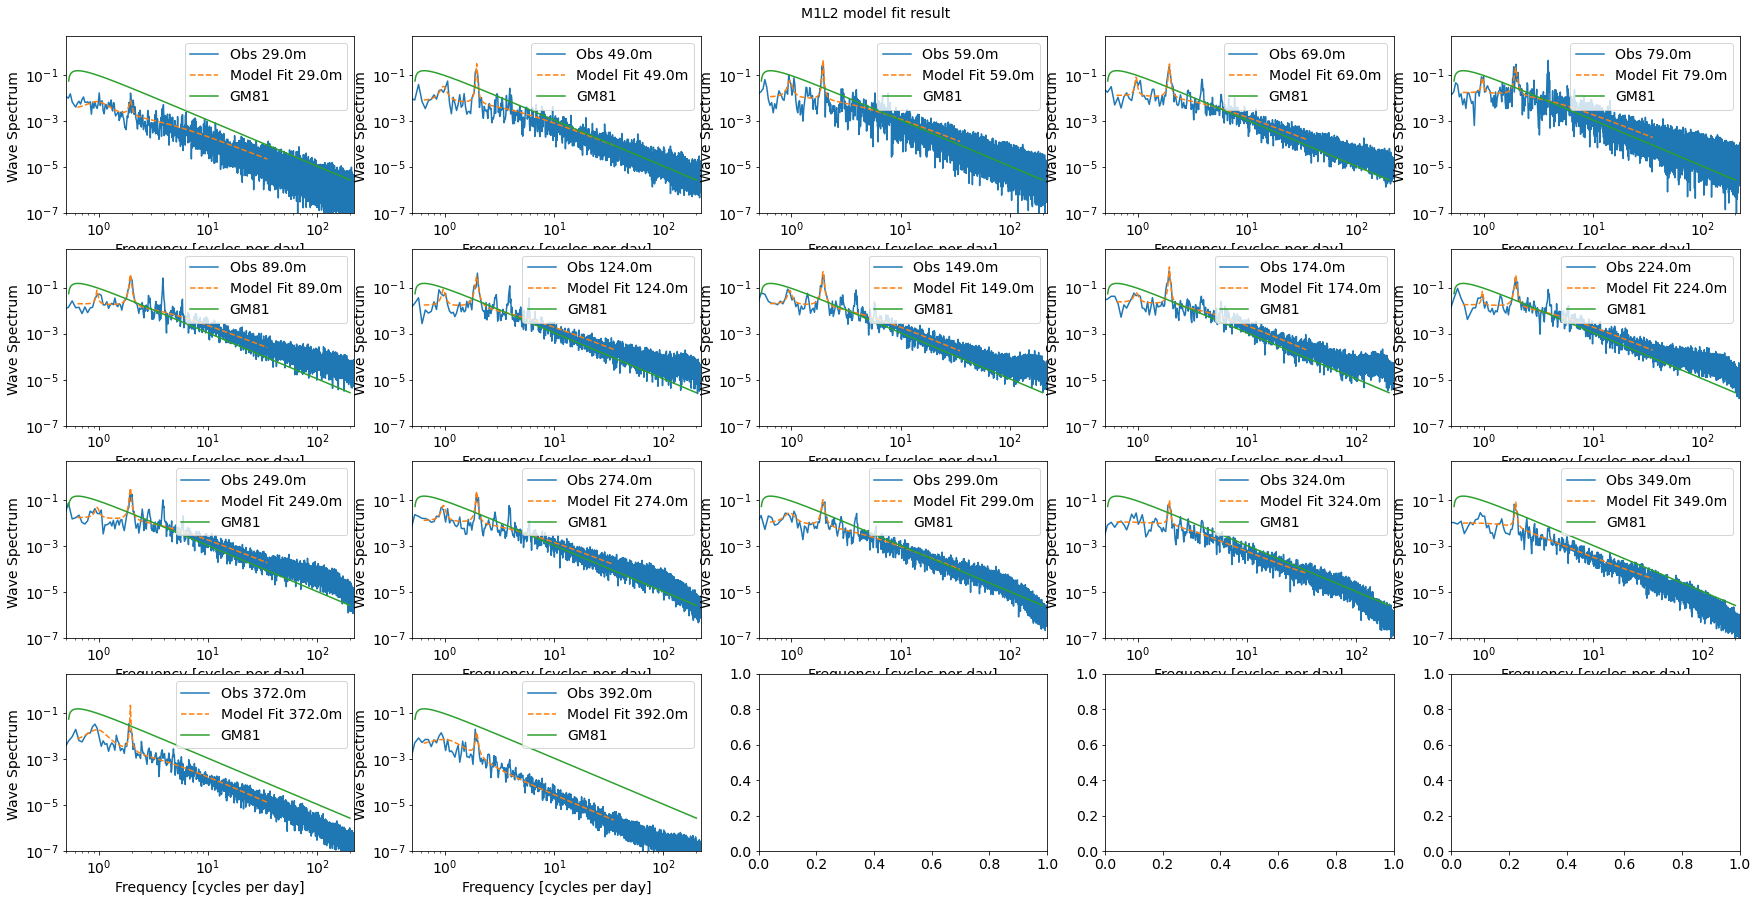

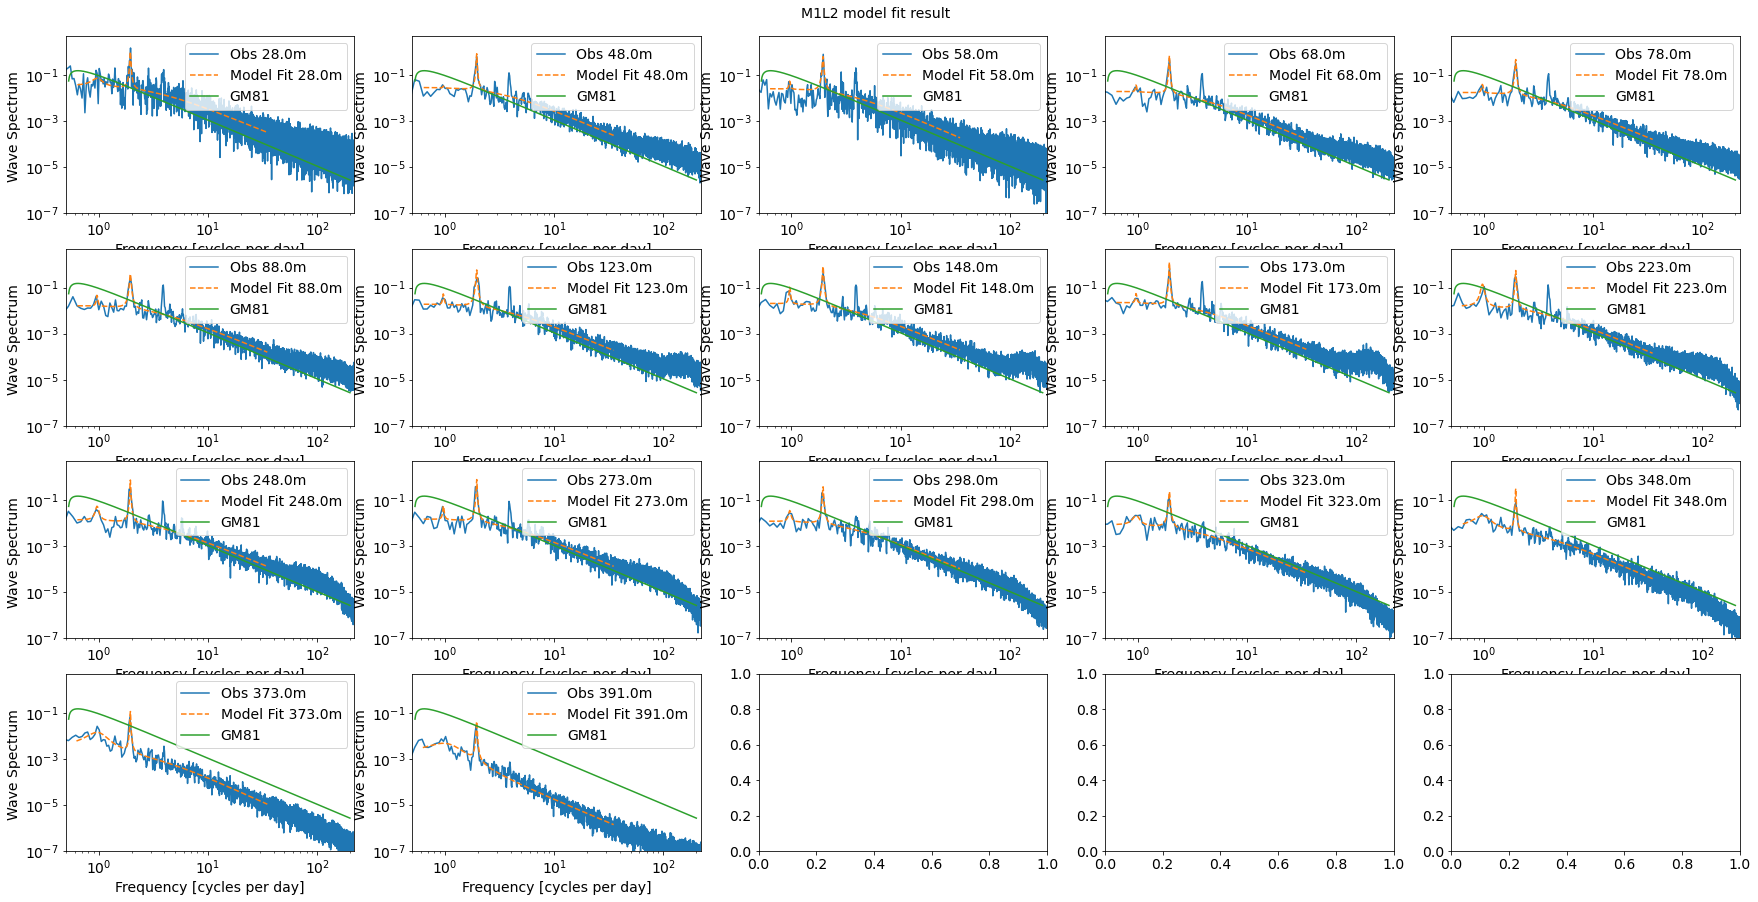

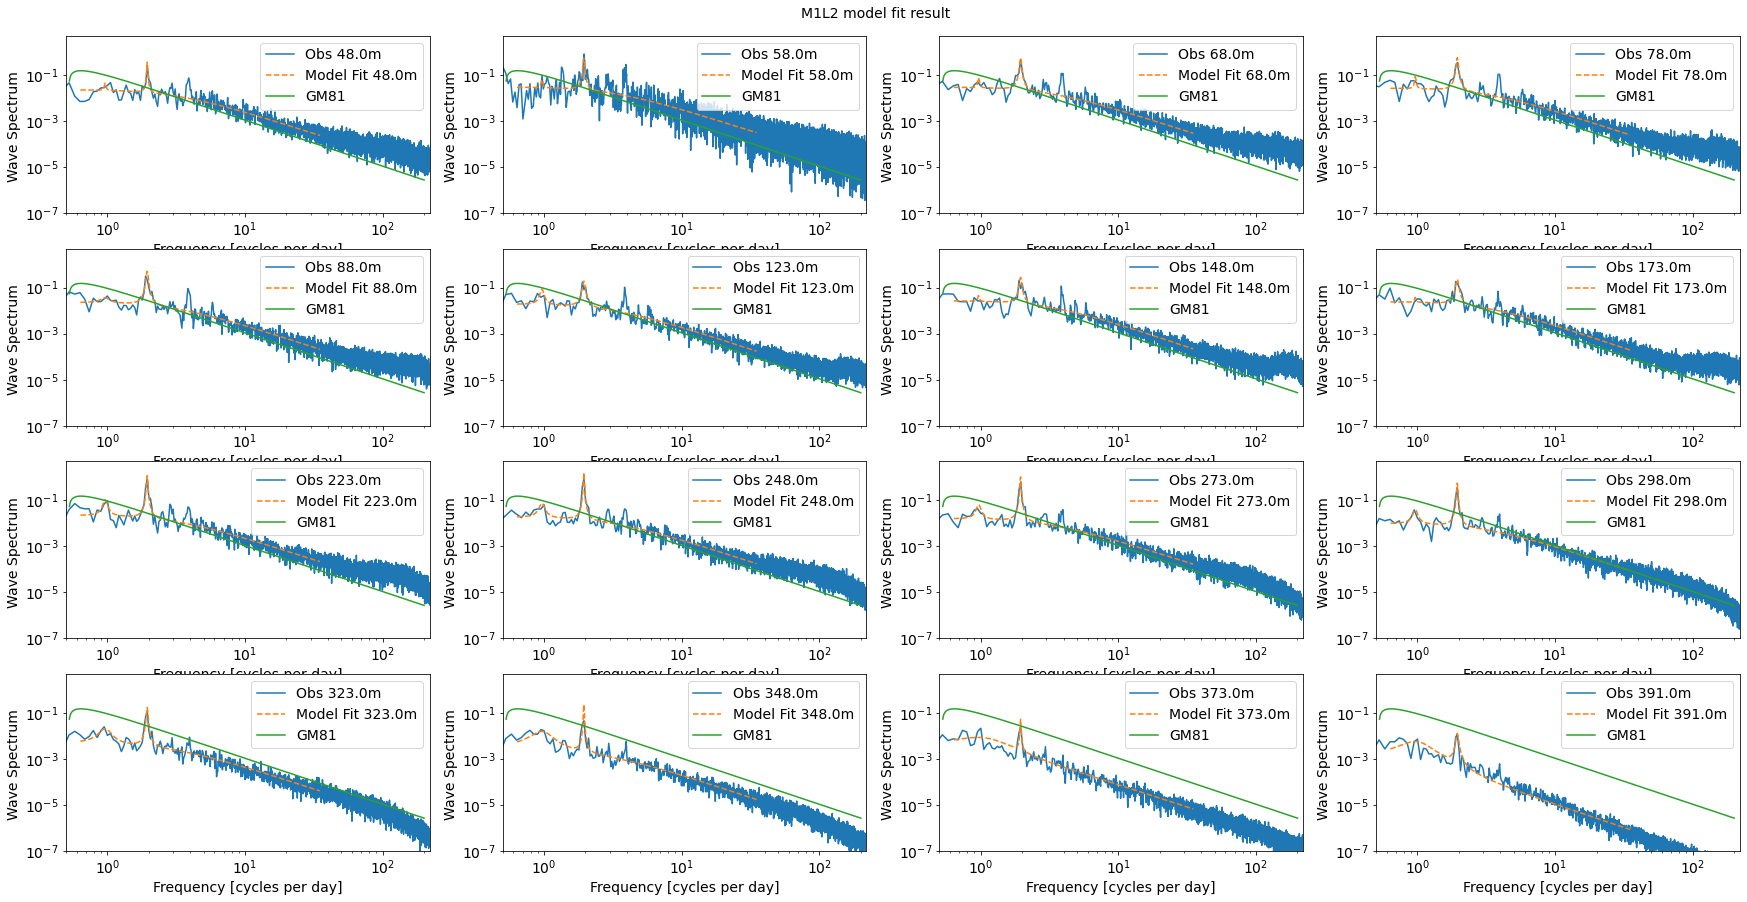

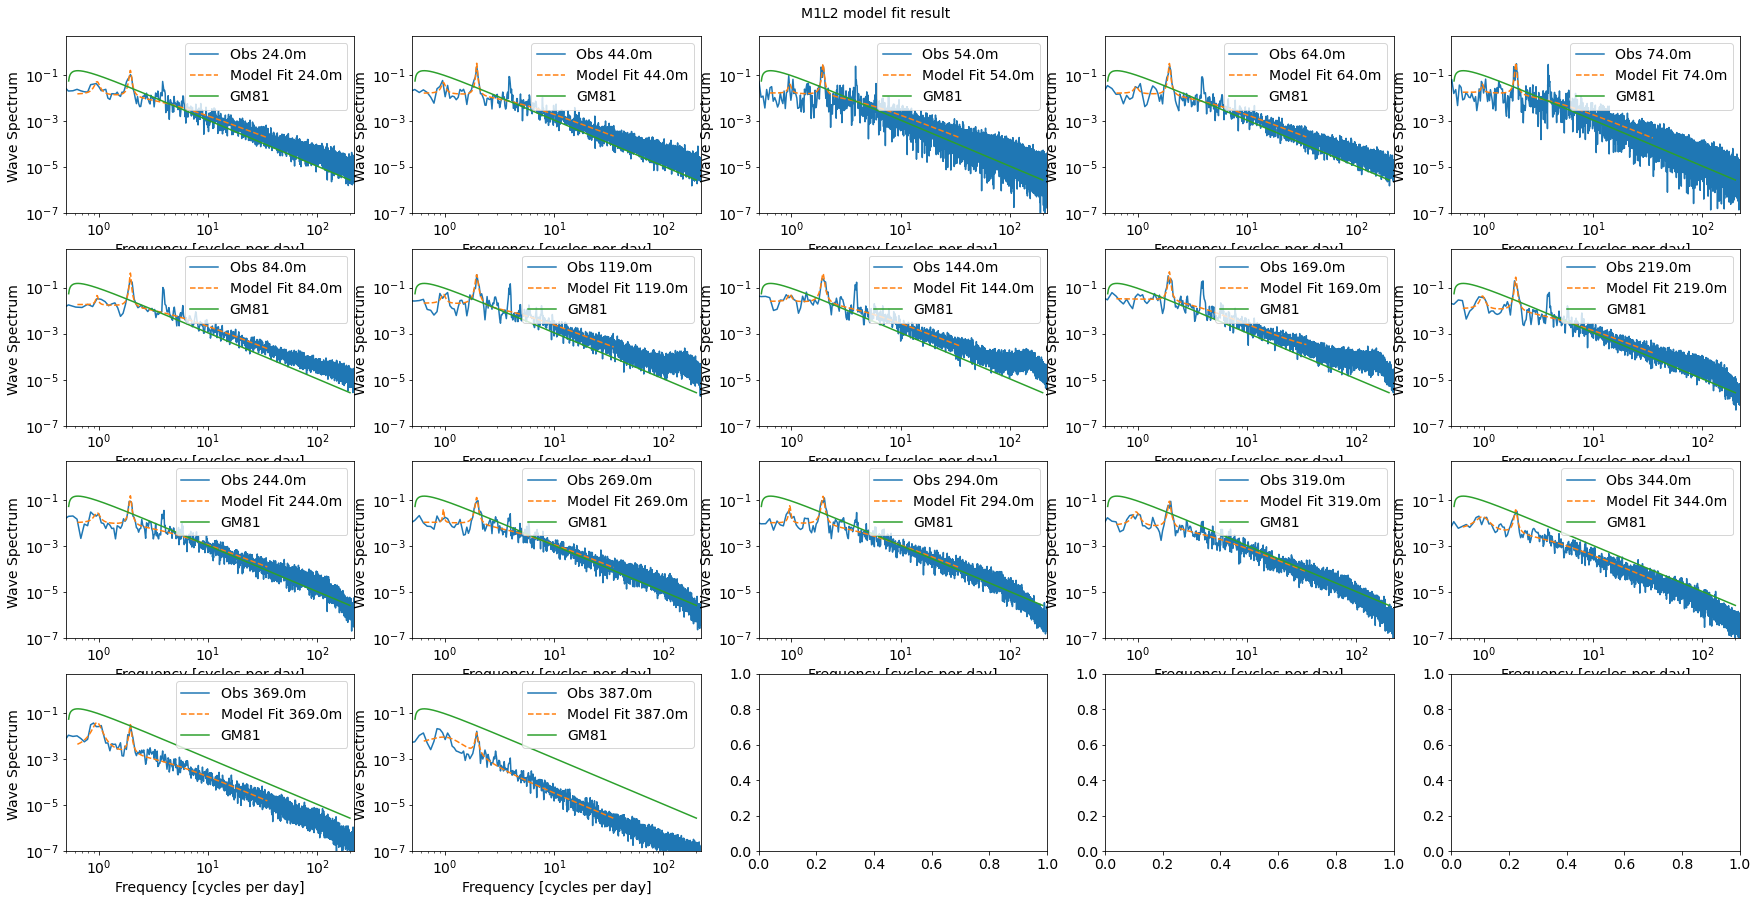

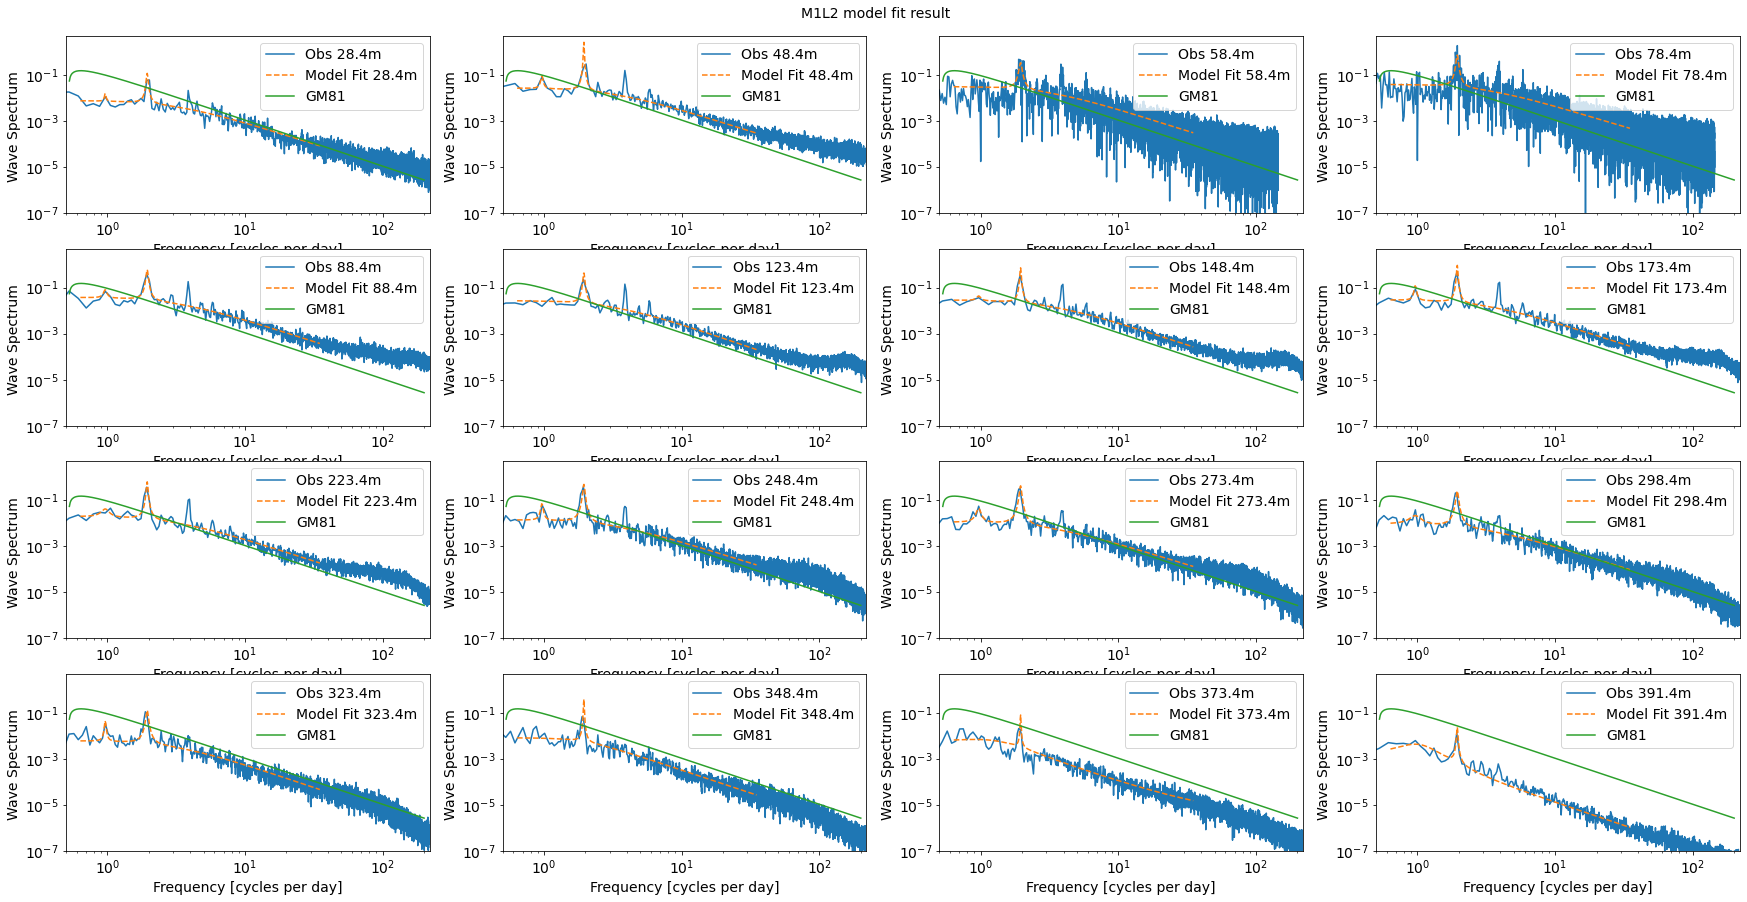

In [67]:
from functions import Plot_figure
#M1L2
Plot_figure.Plot_fit_result_over_depth(Depths_P1, F_w_P1, P_w_P1, 
                                       F_model_fit_list_P1_M1L2,P_model_fit_list_P1_M1L2, 
                                       omg*86400, GM_spectrum/86400,'M1L2')

Plot_figure.Plot_fit_result_over_depth(Depths_P2, F_w_P2, P_w_P2, 
                                       F_model_fit_list_P2_M1L2,P_model_fit_list_P2_M1L2, 
                                       omg*86400, GM_spectrum/86400,'M1L2')

Plot_figure.Plot_fit_result_over_depth(Depths_P3, F_w_P3, P_w_P3, 
                                       F_model_fit_list_P3_M1L2, P_model_fit_list_P3_M1L2, 
                                       omg*86400, GM_spectrum/86400,'M1L2')

Plot_figure.Plot_fit_result_over_depth(Depths_P4, F_w_P4, P_w_P4, 
                                       F_model_fit_list_P4_M1L2, P_model_fit_list_P4_M1L2, 
                                       omg*86400, GM_spectrum/86400,'M1L2')

Plot_figure.Plot_fit_result_over_depth(Depths_P5, F_w_P5, P_w_P5, 
                                       F_model_fit_list_P5_M1L2,P_model_fit_list_P5_M1L2, 
                                       omg*86400, GM_spectrum/86400,'M1L2')

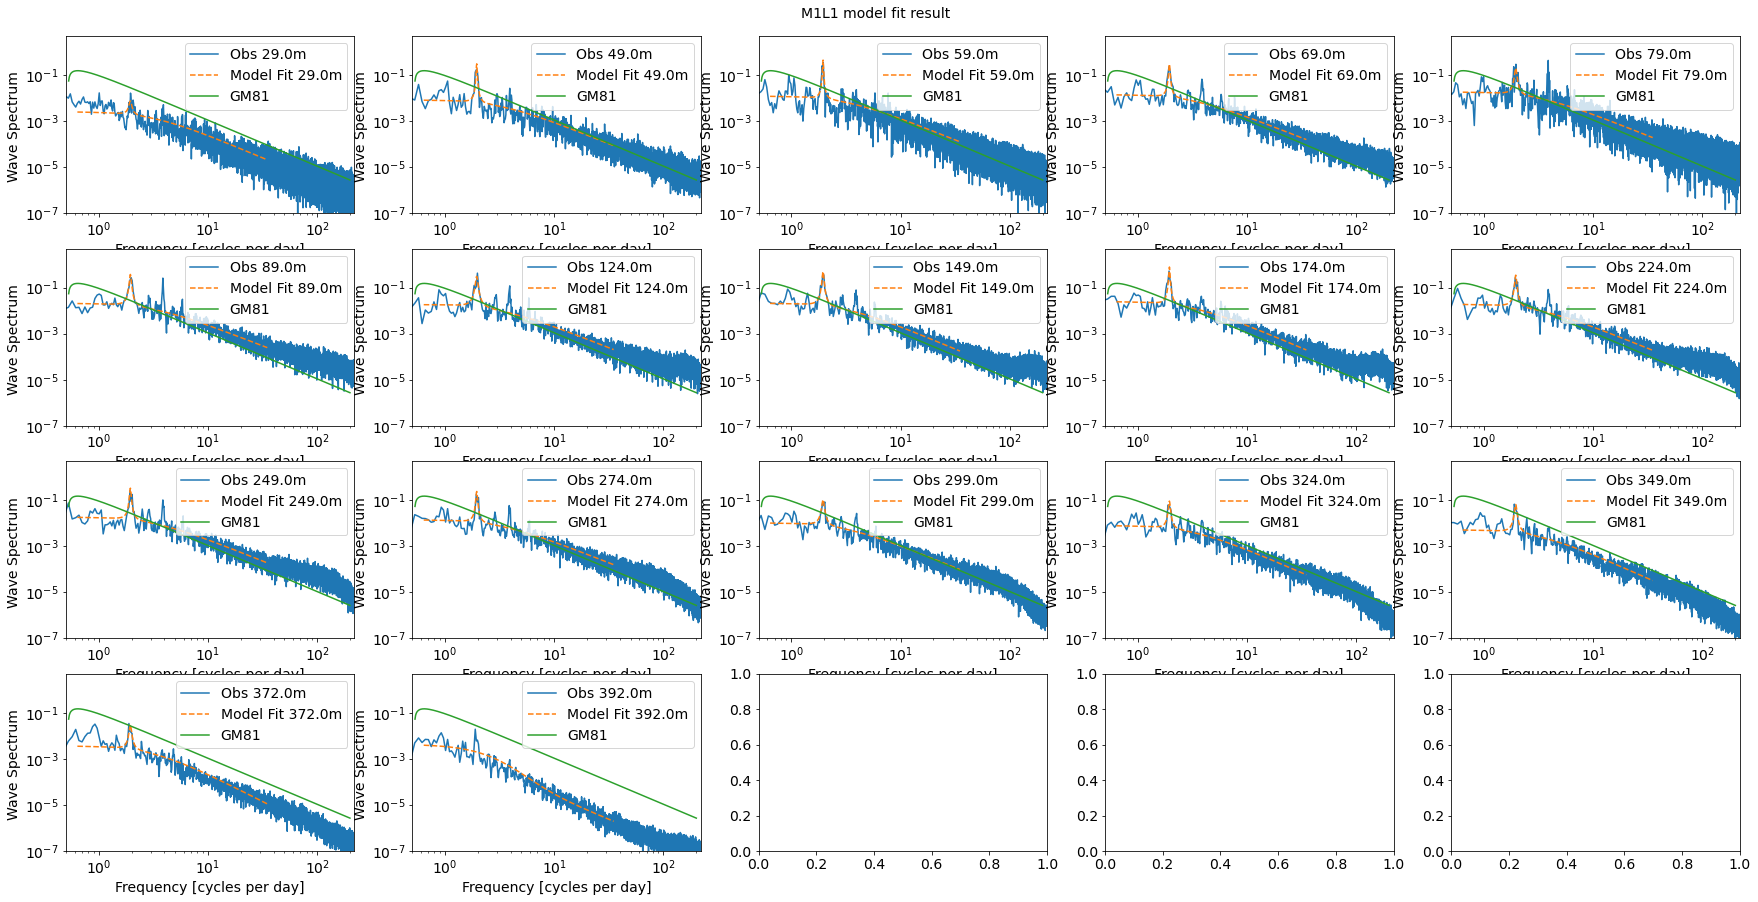

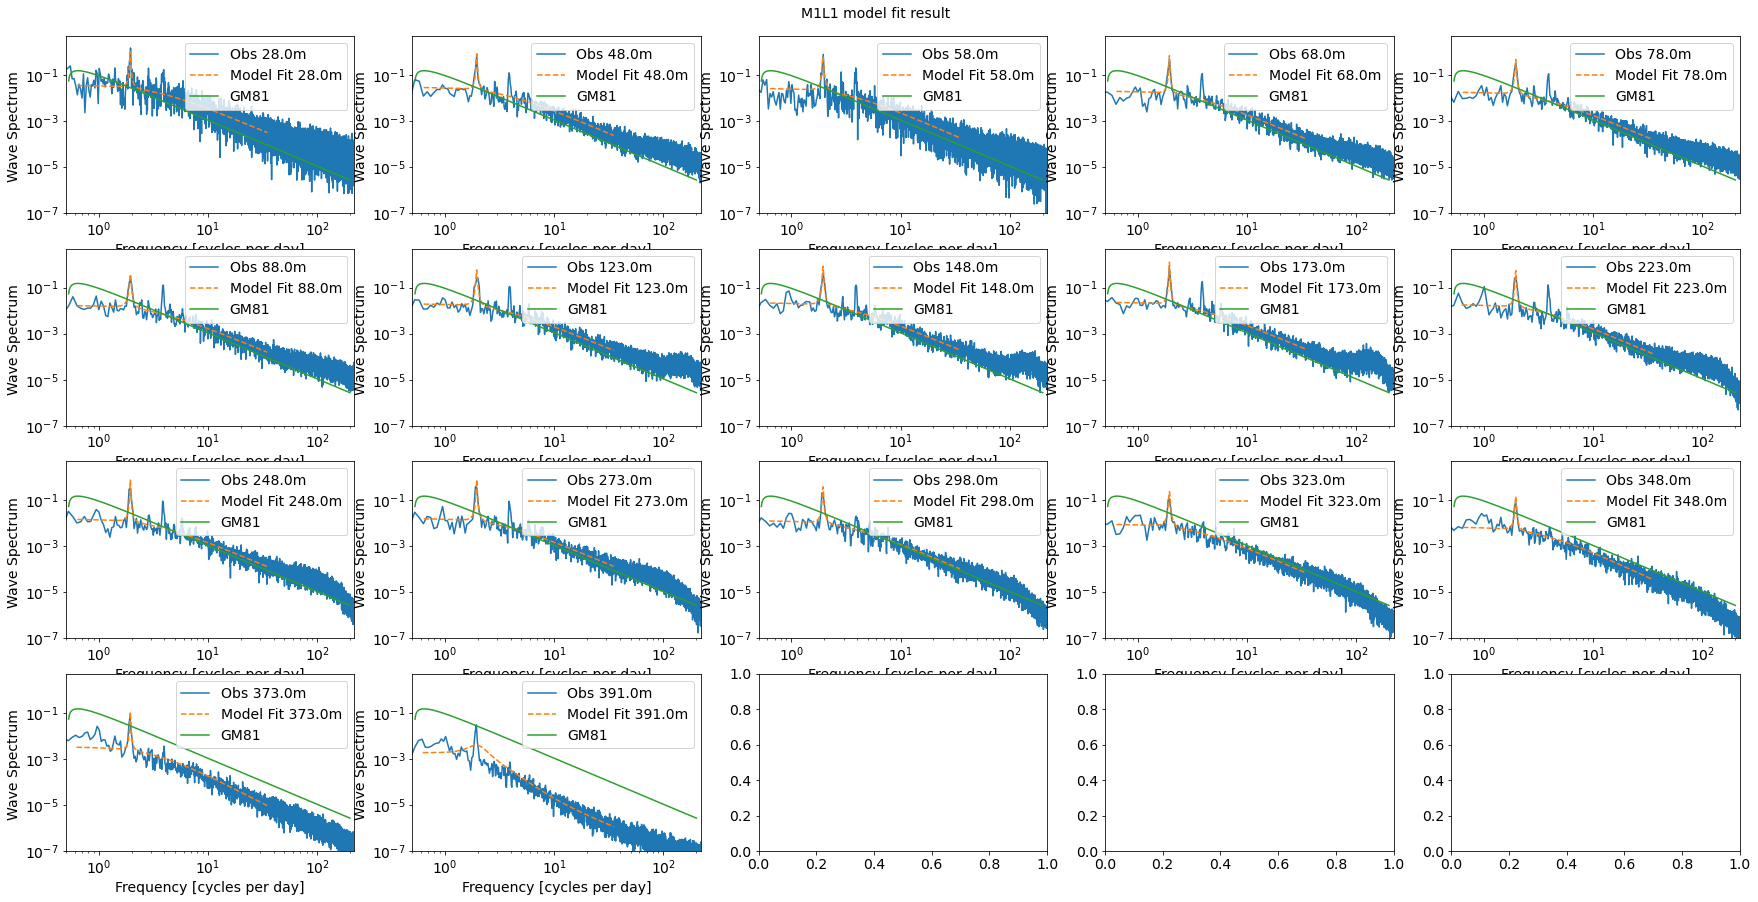

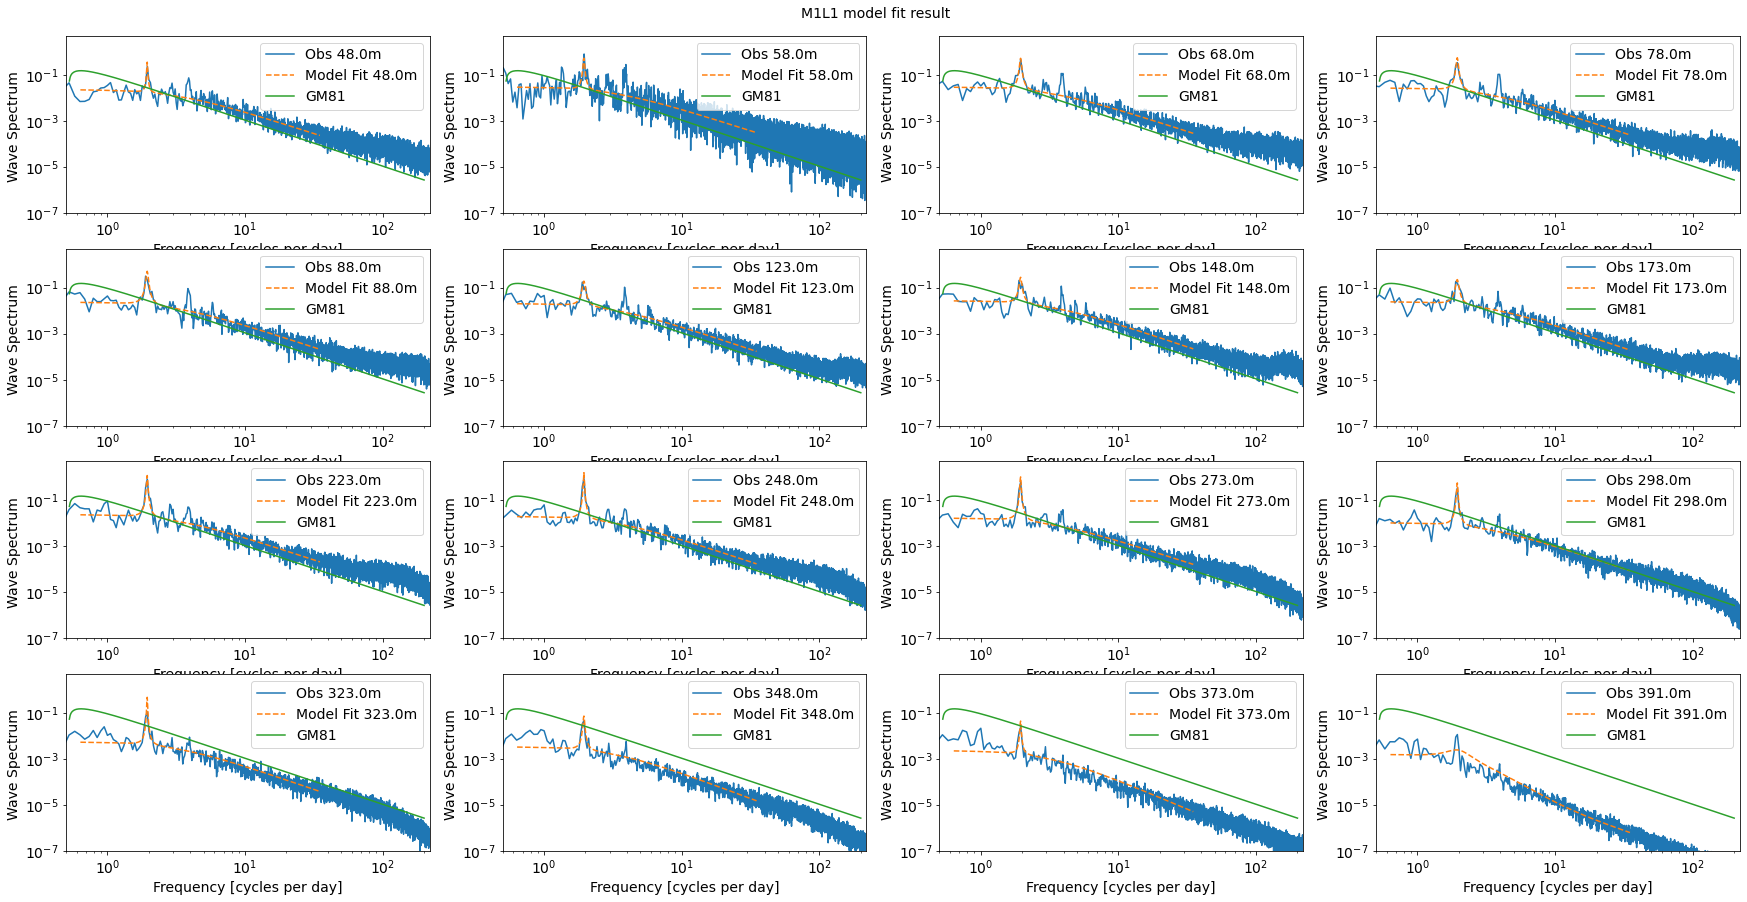

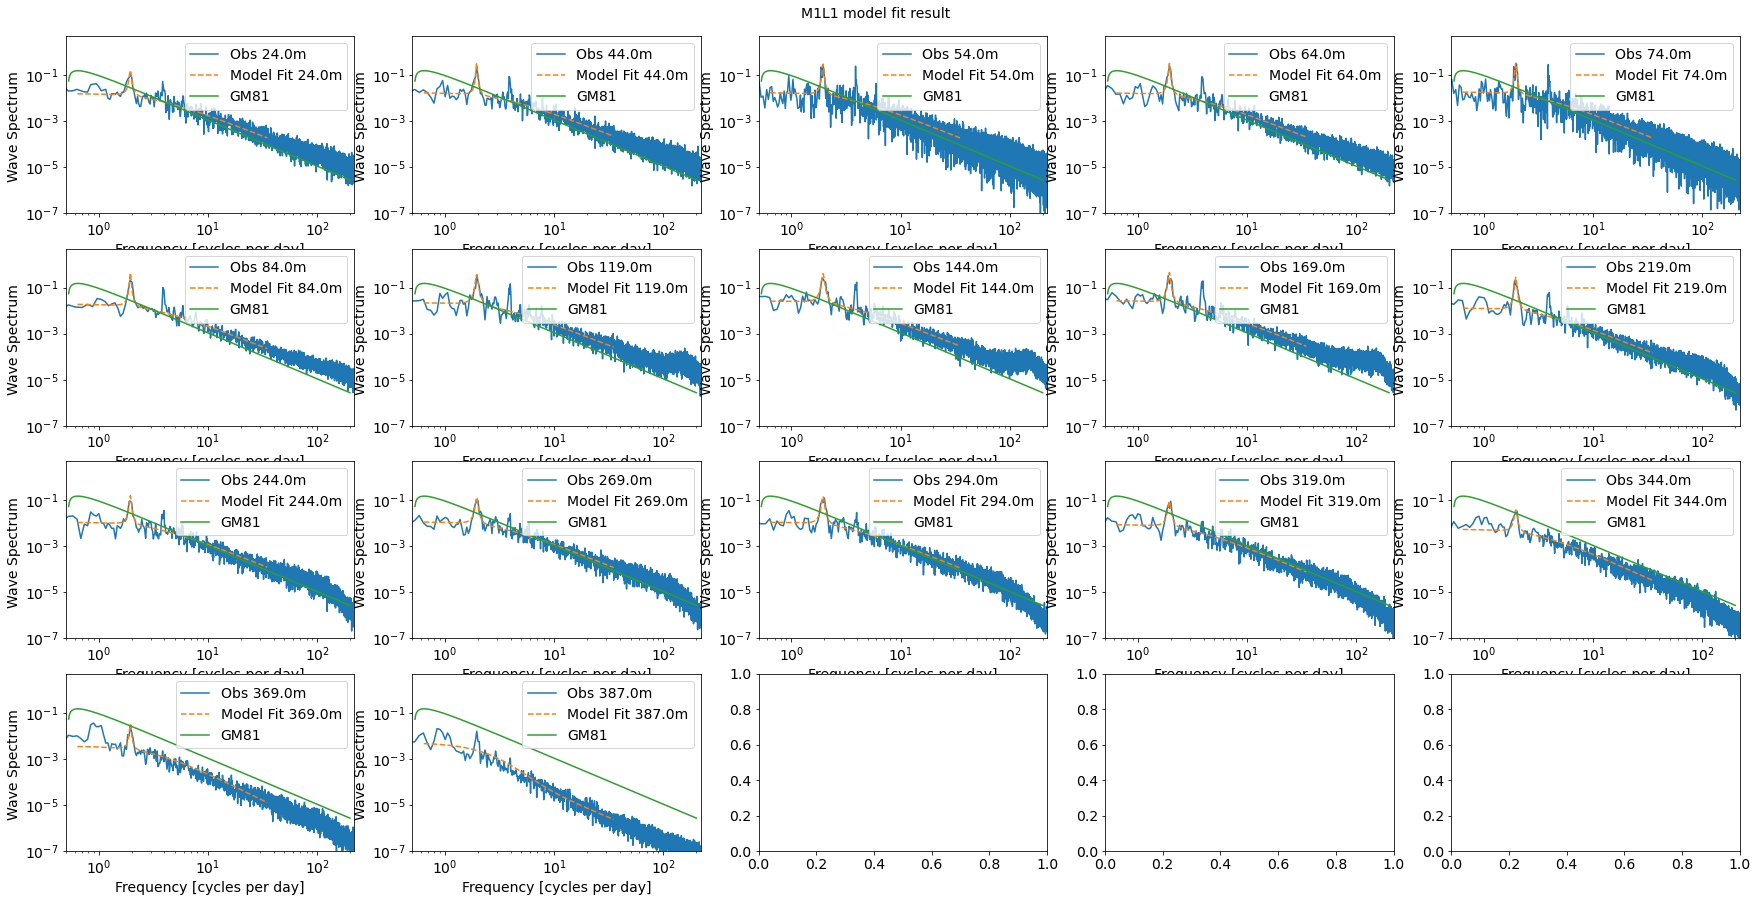

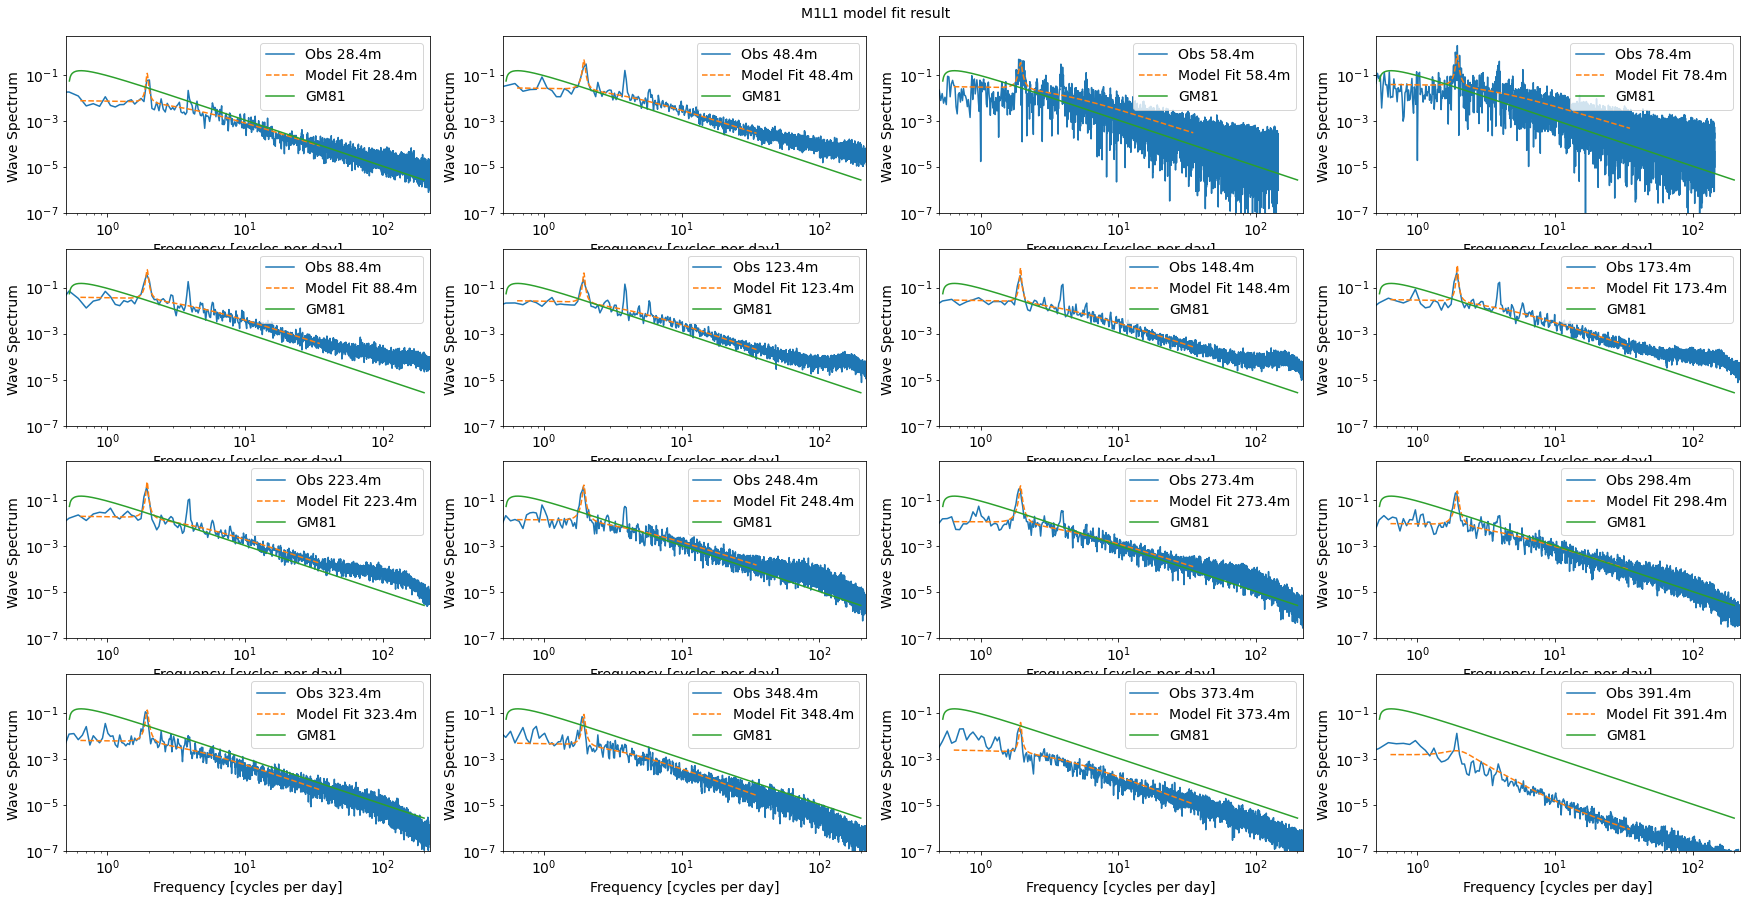

In [68]:
Plot_figure.Plot_fit_result_over_depth(Depths_P1, F_w_P1, P_w_P1, F_model_fit_list_P1_M1L1,
                           P_model_fit_list_P1_M1L1, omg*86400, GM_spectrum/86400,
                           'M1L1')

Plot_figure.Plot_fit_result_over_depth(Depths_P2, F_w_P2, P_w_P2, F_model_fit_list_P2_M1L1,
                           P_model_fit_list_P2_M1L1, omg*86400, GM_spectrum/86400,
                           'M1L1')

Plot_figure.Plot_fit_result_over_depth(Depths_P3, F_w_P3, P_w_P3, F_model_fit_list_P3_M1L1,
                           P_model_fit_list_P3_M1L1, omg*86400, GM_spectrum/86400,
                           'M1L1')

Plot_figure.Plot_fit_result_over_depth(Depths_P4, F_w_P4, P_w_P4, F_model_fit_list_P4_M1L1,
                           P_model_fit_list_P4_M1L1, omg*86400, GM_spectrum/86400,
                           'M1L1')

Plot_figure.Plot_fit_result_over_depth(Depths_P5, F_w_P5, P_w_P5, F_model_fit_list_P5_M1L1,
                           P_model_fit_list_P5_M1L1, omg*86400, GM_spectrum/86400,
                           'M1L1')

# Result Analysis

## Calculate whittle value sequentially

In [82]:
#define diurnal peak freq and bandwidth
diurnal_peak_freq      = 1 #cpd
diurnal_peak_bandwidth = 0.3
#define semidiurnal peak freq and bandwidth
semidiurnal_peak_freq      = 2 #cpd
semidiurnal_peak_bandwidth = 0.5

In [83]:
subset_p_P1_diurnal_peak      = Processing.Subset_peak(F_p_P1,diurnal_peak_freq,diurnal_peak_bandwidth)
subset_w_P1_diurnal_peak      = Processing.Subset_peak(F_w_P1,diurnal_peak_freq,diurnal_peak_bandwidth)
subset_p_P1_semidiurnal_peak  = Processing.Subset_peak(F_p_P1,semidiurnal_peak_freq,semidiurnal_peak_bandwidth)
subset_w_P1_semidiurnal_peak  = Processing.Subset_peak(F_w_P1,semidiurnal_peak_freq,semidiurnal_peak_bandwidth)
subset_p_P1_residual          = Processing.Subset_residual(subset_p_P1_diurnal_peak,subset_p_P1_semidiurnal_peak,subset_p_P1 )
subset_w_P1_residual          = Processing.Subset_residual(subset_w_P1_diurnal_peak,subset_w_P1_semidiurnal_peak,subset_w_P1 )

F_p_P1_L1_peak  = Processing.Select_frequency(F_p_P1,subset_p_P1_diurnal_peak)
P_p_P1_L1_peak  = Processing.Select_frequency(P_p_P1,subset_p_P1_diurnal_peak )
F_p_P1_L2_peak  = Processing.Select_frequency(F_p_P1,subset_p_P1_semidiurnal_peak  )
P_p_P1_L2_peak  = Processing.Select_frequency(P_p_P1,subset_p_P1_semidiurnal_peak  )
F_p_P1_residual = Processing.Select_frequency(F_p_P1,subset_p_P1_residual )
P_p_P1_residual = Processing.Select_frequency(P_p_P1,subset_p_P1_residual )

In [84]:
subset_p_P2_diurnal_peak      = Processing.Subset_peak(F_p_P2,diurnal_peak_freq,diurnal_peak_bandwidth)
subset_w_P2_diurnal_peak      = Processing.Subset_peak(F_w_P2,diurnal_peak_freq,diurnal_peak_bandwidth)
subset_p_P2_semidiurnal_peak  = Processing.Subset_peak(F_p_P2,semidiurnal_peak_freq,semidiurnal_peak_bandwidth)
subset_w_P2_semidiurnal_peak  = Processing.Subset_peak(F_w_P2,semidiurnal_peak_freq,semidiurnal_peak_bandwidth)
subset_p_P2_residual          = Processing.Subset_residual(subset_p_P2_diurnal_peak,subset_p_P2_semidiurnal_peak,subset_p_P2 )
subset_w_P2_residual          = Processing.Subset_residual(subset_w_P2_diurnal_peak,subset_w_P2_semidiurnal_peak,subset_w_P2 )

F_p_P2_L1_peak  = Processing.Select_frequency(F_p_P2,subset_p_P2_diurnal_peak)
P_p_P2_L1_peak  = Processing.Select_frequency(P_p_P2,subset_p_P2_diurnal_peak )
F_p_P2_L2_peak  = Processing.Select_frequency(F_p_P2,subset_p_P2_semidiurnal_peak  )
P_p_P2_L2_peak  = Processing.Select_frequency(P_p_P2,subset_p_P2_semidiurnal_peak  )
F_p_P2_residual = Processing.Select_frequency(F_p_P2,subset_p_P2_residual )
P_p_P2_residual = Processing.Select_frequency(P_p_P2,subset_p_P2_residual )

In [85]:
subset_p_P3_diurnal_peak      = Processing.Subset_peak(F_p_P3,diurnal_peak_freq,diurnal_peak_bandwidth)
subset_w_P3_diurnal_peak      = Processing.Subset_peak(F_w_P3,diurnal_peak_freq,diurnal_peak_bandwidth)
subset_p_P3_semidiurnal_peak  = Processing.Subset_peak(F_p_P3,semidiurnal_peak_freq,semidiurnal_peak_bandwidth)
subset_w_P3_semidiurnal_peak  = Processing.Subset_peak(F_w_P3,semidiurnal_peak_freq,semidiurnal_peak_bandwidth)
subset_p_P3_residual          = Processing.Subset_residual(subset_p_P3_diurnal_peak,subset_p_P3_semidiurnal_peak,subset_p_P3 )
subset_w_P3_residual          = Processing.Subset_residual(subset_w_P3_diurnal_peak,subset_w_P3_semidiurnal_peak,subset_w_P3 )

F_p_P3_L1_peak  = Processing.Select_frequency(F_p_P3,subset_p_P3_diurnal_peak)
P_p_P3_L1_peak  = Processing.Select_frequency(P_p_P3,subset_p_P3_diurnal_peak )
F_p_P3_L2_peak  = Processing.Select_frequency(F_p_P3,subset_p_P3_semidiurnal_peak  )
P_p_P3_L2_peak  = Processing.Select_frequency(P_p_P3,subset_p_P3_semidiurnal_peak  )
F_p_P3_residual = Processing.Select_frequency(F_p_P3,subset_p_P3_residual )
P_p_P3_residual = Processing.Select_frequency(P_p_P3,subset_p_P3_residual )

In [86]:
subset_p_P4_diurnal_peak      = Processing.Subset_peak(F_p_P4,diurnal_peak_freq,diurnal_peak_bandwidth)
subset_w_P4_diurnal_peak      = Processing.Subset_peak(F_w_P4,diurnal_peak_freq,diurnal_peak_bandwidth)
subset_p_P4_semidiurnal_peak  = Processing.Subset_peak(F_p_P4,semidiurnal_peak_freq,semidiurnal_peak_bandwidth)
subset_w_P4_semidiurnal_peak  = Processing.Subset_peak(F_w_P4,semidiurnal_peak_freq,semidiurnal_peak_bandwidth)
subset_p_P4_residual          = Processing.Subset_residual(subset_p_P4_diurnal_peak,subset_p_P4_semidiurnal_peak,subset_p_P4 )
subset_w_P4_residual          = Processing.Subset_residual(subset_w_P4_diurnal_peak,subset_w_P4_semidiurnal_peak,subset_w_P4 )

F_p_P4_L1_peak  = Processing.Select_frequency(F_p_P4,subset_p_P4_diurnal_peak)
P_p_P4_L1_peak  = Processing.Select_frequency(P_p_P4,subset_p_P4_diurnal_peak )
F_p_P4_L2_peak  = Processing.Select_frequency(F_p_P4,subset_p_P4_semidiurnal_peak  )
P_p_P4_L2_peak  = Processing.Select_frequency(P_p_P4,subset_p_P4_semidiurnal_peak  )
F_p_P4_residual = Processing.Select_frequency(F_p_P4,subset_p_P4_residual )
P_p_P4_residual = Processing.Select_frequency(P_p_P4,subset_p_P4_residual )

In [87]:
subset_p_P5_diurnal_peak      = Processing.Subset_peak(F_p_P5,diurnal_peak_freq,diurnal_peak_bandwidth)
subset_w_P5_diurnal_peak      = Processing.Subset_peak(F_w_P5,diurnal_peak_freq,diurnal_peak_bandwidth)
subset_p_P5_semidiurnal_peak  = Processing.Subset_peak(F_p_P5,semidiurnal_peak_freq,semidiurnal_peak_bandwidth)
subset_w_P5_semidiurnal_peak  = Processing.Subset_peak(F_w_P5,semidiurnal_peak_freq,semidiurnal_peak_bandwidth)
subset_p_P5_residual          = Processing.Subset_residual(subset_p_P5_diurnal_peak,subset_p_P5_semidiurnal_peak,subset_p_P5 )
subset_w_P5_residual          = Processing.Subset_residual(subset_w_P5_diurnal_peak,subset_w_P5_semidiurnal_peak,subset_w_P5 )

F_p_P5_L1_peak  = Processing.Select_frequency(F_p_P5,subset_p_P5_diurnal_peak)
P_p_P5_L1_peak  = Processing.Select_frequency(P_p_P5,subset_p_P5_diurnal_peak )
F_p_P5_L2_peak  = Processing.Select_frequency(F_p_P5,subset_p_P5_semidiurnal_peak  )
P_p_P5_L2_peak  = Processing.Select_frequency(P_p_P5,subset_p_P5_semidiurnal_peak  )
F_p_P5_residual = Processing.Select_frequency(F_p_P5,subset_p_P5_residual )
P_p_P5_residual = Processing.Select_frequency(P_p_P5,subset_p_P5_residual )

Text(0.5, 1.0, 'Segmentation of temp residual spectrum at 89m')

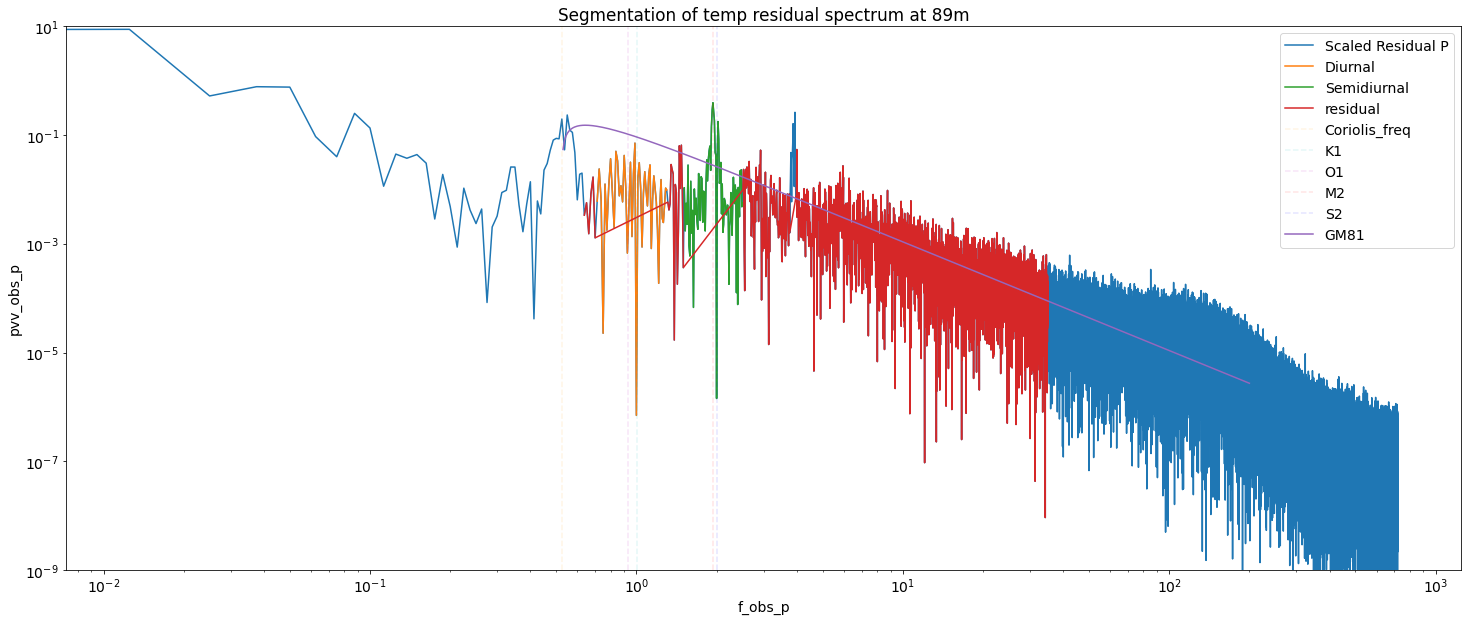

In [88]:
# total depth is ~400m
# interest_depth = 110.7
idx = Depths_P1.index(interest_depth)

plt.plot(F_p_P1[idx][0],P_p_P1[idx][0],label='Scaled Residual P')
# plt.plot(F_p_P1_modulated[idx][0],P_p_P1_modulated[idx][0],label='Processed & scaled Residual P')
plt.plot(F_p_P1_L1_peak[idx][0],P_p_P1_L1_peak[idx][0],label='Diurnal')
plt.plot(F_p_P1_L2_peak[idx][0],P_p_P1_L2_peak[idx][0],label='Semidiurnal')
plt.plot(F_p_P1_residual[idx][0],P_p_P1_residual[idx][0],label='residual')


for j in range(len(xcoords)):
    plt.axvline(x=xcoords[j],linestyle='--', color=xcoords_color[j], label=xcoords_label[j],alpha=0.105)

# plt.plot(F_residual_w[idx],P_residual_w_raw[idx],label='Raw Obs Residual W')
# plt.plot(F_residual_w[idx],P_residual_w[idx],'-.',label='Scaled Residual W')
# plt.plot(F_residual_w_Modulated[idx],P_residual_w_Modulated[idx],'-.',label='Processed & scaled Residual W')
plt.plot(omg*86400,GM_spectrum/86400,label = 'GM81')
plt.legend()
plt.ylim(1e-9, 1e1)
# plt.xlim(0, 5)
plt.ylabel('pvv_obs_p')
plt.xlabel('f_obs_p')
plt.xscale("log")
plt.yscale("log")
plt.title('Segmentation of temp residual spectrum at {}m'.format(interest_depth))

In [95]:
#whittle_total per points
whittle_total_M1L1_P1        = Optimisation.Cal_whittle_value_per_points(P_p_P1,Time_P1_Window,subset_p_P1,                Soln_model_fit_list_P1_M1L1,M1L1_no_noise)
#whittle_diurnal perak per points
whittle_diurnal_M1L1_P1      = Optimisation.Cal_whittle_value_per_points(P_p_P1,Time_P1_Window,subset_p_P1_diurnal_peak,   Soln_model_fit_list_P1_M1L1,M1L1_no_noise)
#whittle_semidurnal per points
whittle_semidiurnal_M1L1_P1  = Optimisation.Cal_whittle_value_per_points(P_p_P1,Time_P1_Window,subset_p_P1_semidiurnal_peak,Soln_model_fit_list_P1_M1L1,M1L1_no_noise)
#whittle_residual per points
whittle_residual_M1L1_P1     = Optimisation.Cal_whittle_value_per_points(P_p_P1,Time_P1_Window,subset_p_P1_residual,        Soln_model_fit_list_P1_M1L1,M1L1_no_noise)

whittle_total_M1L2_P1         = Optimisation.Cal_whittle_value_per_points(P_p_P1,Time_P1_Window,subset_p_P1,                 Soln_model_fit_list_P1_M1L2,M1L2_no_noise)
whittle_diurnal_M1L2_P1      = Optimisation.Cal_whittle_value_per_points(P_p_P1,Time_P1_Window,subset_p_P1_diurnal_peak,    Soln_model_fit_list_P1_M1L2,M1L2_no_noise)
whittle_semidiurnal_M1L2_P1  = Optimisation.Cal_whittle_value_per_points(P_p_P1,Time_P1_Window,subset_p_P1_semidiurnal_peak,Soln_model_fit_list_P1_M1L2,M1L2_no_noise)
whittle_residual_M1L2_P1     = Optimisation.Cal_whittle_value_per_points(P_p_P1,Time_P1_Window,subset_p_P1_residual,        Soln_model_fit_list_P1_M1L2,M1L2_no_noise)

C:\Users\21924032\GitHub\Yutao_PhD_codes\Yutao Aim1 Internal Tide\notebooks\1D internal tide temp model fit V1.2\functions\Cov.py:114: RuntimeWarning: invalid value encountered in multiply
  K *= K_nu(nu, np.abs(lmbda * dx))


In [96]:
#whittle_total per points
whittle_total_M1L1_P2        = Optimisation.Cal_whittle_value_per_points(P_p_P2,Time_P2_Window,subset_p_P2,                Soln_model_fit_list_P2_M1L1,M1L1_no_noise)
#whittle_diurnal perak per points
whittle_diurnal_M1L1_P2      = Optimisation.Cal_whittle_value_per_points(P_p_P2,Time_P2_Window,subset_p_P2_diurnal_peak,   Soln_model_fit_list_P2_M1L1,M1L1_no_noise)
#whittle_semidurnal per points
whittle_semidiurnal_M1L1_P2  = Optimisation.Cal_whittle_value_per_points(P_p_P2,Time_P2_Window,subset_p_P2_semidiurnal_peak,Soln_model_fit_list_P2_M1L1,M1L1_no_noise)
#whittle_residual per points
whittle_residual_M1L1_P2     = Optimisation.Cal_whittle_value_per_points(P_p_P2,Time_P2_Window,subset_p_P2_residual,        Soln_model_fit_list_P2_M1L1,M1L1_no_noise)

whittle_total_M1L2_P2         = Optimisation.Cal_whittle_value_per_points(P_p_P2,Time_P2_Window,subset_p_P2,                 Soln_model_fit_list_P2_M1L2,M1L2_no_noise)
whittle_diurnal_M1L2_P2      = Optimisation.Cal_whittle_value_per_points(P_p_P2,Time_P2_Window,subset_p_P2_diurnal_peak,    Soln_model_fit_list_P2_M1L2,M1L2_no_noise)
whittle_semidiurnal_M1L2_P2  = Optimisation.Cal_whittle_value_per_points(P_p_P2,Time_P2_Window,subset_p_P2_semidiurnal_peak,Soln_model_fit_list_P2_M1L2,M1L2_no_noise)
whittle_residual_M1L2_P2     = Optimisation.Cal_whittle_value_per_points(P_p_P2,Time_P2_Window,subset_p_P2_residual,        Soln_model_fit_list_P2_M1L2,M1L2_no_noise)

C:\Users\21924032\GitHub\Yutao_PhD_codes\Yutao Aim1 Internal Tide\notebooks\1D internal tide temp model fit V1.2\functions\Cov.py:114: RuntimeWarning: invalid value encountered in multiply
  K *= K_nu(nu, np.abs(lmbda * dx))


In [97]:
#whittle_total per points
whittle_total_M1L1_P3        = Optimisation.Cal_whittle_value_per_points(P_p_P3,Time_P3_Window,subset_p_P3,                Soln_model_fit_list_P3_M1L1,M1L1_no_noise)
#whittle_diurnal perak per points
whittle_diurnal_M1L1_P3      = Optimisation.Cal_whittle_value_per_points(P_p_P3,Time_P3_Window,subset_p_P3_diurnal_peak,   Soln_model_fit_list_P3_M1L1,M1L1_no_noise)
#whittle_semidurnal per points
whittle_semidiurnal_M1L1_P3  = Optimisation.Cal_whittle_value_per_points(P_p_P3,Time_P3_Window,subset_p_P3_semidiurnal_peak,Soln_model_fit_list_P3_M1L1,M1L1_no_noise)
#whittle_residual per points
whittle_residual_M1L1_P3     = Optimisation.Cal_whittle_value_per_points(P_p_P3,Time_P3_Window,subset_p_P3_residual,        Soln_model_fit_list_P3_M1L1,M1L1_no_noise)

whittle_total_M1L2_P3         = Optimisation.Cal_whittle_value_per_points(P_p_P3,Time_P3_Window,subset_p_P3,                 Soln_model_fit_list_P3_M1L2,M1L2_no_noise)
whittle_diurnal_M1L2_P3      = Optimisation.Cal_whittle_value_per_points(P_p_P3,Time_P3_Window,subset_p_P3_diurnal_peak,    Soln_model_fit_list_P3_M1L2,M1L2_no_noise)
whittle_semidiurnal_M1L2_P3  = Optimisation.Cal_whittle_value_per_points(P_p_P3,Time_P3_Window,subset_p_P3_semidiurnal_peak,Soln_model_fit_list_P3_M1L2,M1L2_no_noise)
whittle_residual_M1L2_P3     = Optimisation.Cal_whittle_value_per_points(P_p_P3,Time_P3_Window,subset_p_P3_residual,        Soln_model_fit_list_P3_M1L2,M1L2_no_noise)

C:\Users\21924032\GitHub\Yutao_PhD_codes\Yutao Aim1 Internal Tide\notebooks\1D internal tide temp model fit V1.2\functions\Cov.py:114: RuntimeWarning: invalid value encountered in multiply
  K *= K_nu(nu, np.abs(lmbda * dx))


In [98]:
#whittle_total per points
whittle_total_M1L1_P4        = Optimisation.Cal_whittle_value_per_points(P_p_P4,Time_P4_Window,subset_p_P4,                Soln_model_fit_list_P4_M1L1,M1L1_no_noise)
#whittle_diurnal perak per points
whittle_diurnal_M1L1_P4      = Optimisation.Cal_whittle_value_per_points(P_p_P4,Time_P4_Window,subset_p_P4_diurnal_peak,   Soln_model_fit_list_P4_M1L1,M1L1_no_noise)
#whittle_semidurnal per points
whittle_semidiurnal_M1L1_P4  = Optimisation.Cal_whittle_value_per_points(P_p_P4,Time_P4_Window,subset_p_P4_semidiurnal_peak,Soln_model_fit_list_P4_M1L1,M1L1_no_noise)
#whittle_residual per points
whittle_residual_M1L1_P4     = Optimisation.Cal_whittle_value_per_points(P_p_P4,Time_P4_Window,subset_p_P4_residual,        Soln_model_fit_list_P4_M1L1,M1L1_no_noise)

whittle_total_M1L2_P4         = Optimisation.Cal_whittle_value_per_points(P_p_P4,Time_P4_Window,subset_p_P4,                 Soln_model_fit_list_P4_M1L2,M1L2_no_noise)
whittle_diurnal_M1L2_P4      = Optimisation.Cal_whittle_value_per_points(P_p_P4,Time_P4_Window,subset_p_P4_diurnal_peak,    Soln_model_fit_list_P4_M1L2,M1L2_no_noise)
whittle_semidiurnal_M1L2_P4  = Optimisation.Cal_whittle_value_per_points(P_p_P4,Time_P4_Window,subset_p_P4_semidiurnal_peak,Soln_model_fit_list_P4_M1L2,M1L2_no_noise)
whittle_residual_M1L2_P4     = Optimisation.Cal_whittle_value_per_points(P_p_P4,Time_P4_Window,subset_p_P4_residual,        Soln_model_fit_list_P4_M1L2,M1L2_no_noise)

C:\Users\21924032\GitHub\Yutao_PhD_codes\Yutao Aim1 Internal Tide\notebooks\1D internal tide temp model fit V1.2\functions\Cov.py:114: RuntimeWarning: invalid value encountered in multiply
  K *= K_nu(nu, np.abs(lmbda * dx))


In [99]:
#whittle_total per points
whittle_total_M1L1_P5        = Optimisation.Cal_whittle_value_per_points(P_p_P5,Time_P5_Window,subset_p_P5,                Soln_model_fit_list_P5_M1L1,M1L1_no_noise)
#whittle_diurnal perak per points
whittle_diurnal_M1L1_P5      = Optimisation.Cal_whittle_value_per_points(P_p_P5,Time_P5_Window,subset_p_P5_diurnal_peak,   Soln_model_fit_list_P5_M1L1,M1L1_no_noise)
#whittle_semidurnal per points
whittle_semidiurnal_M1L1_P5  = Optimisation.Cal_whittle_value_per_points(P_p_P5,Time_P5_Window,subset_p_P5_semidiurnal_peak,Soln_model_fit_list_P5_M1L1,M1L1_no_noise)
#whittle_residual per points
whittle_residual_M1L1_P5     = Optimisation.Cal_whittle_value_per_points(P_p_P5,Time_P5_Window,subset_p_P5_residual,        Soln_model_fit_list_P5_M1L1,M1L1_no_noise)

whittle_total_M1L2_P5         = Optimisation.Cal_whittle_value_per_points(P_p_P5,Time_P5_Window,subset_p_P5,                 Soln_model_fit_list_P5_M1L2,M1L2_no_noise)
whittle_diurnal_M1L2_P5      = Optimisation.Cal_whittle_value_per_points(P_p_P5,Time_P5_Window,subset_p_P5_diurnal_peak,    Soln_model_fit_list_P5_M1L2,M1L2_no_noise)
whittle_semidiurnal_M1L2_P5  = Optimisation.Cal_whittle_value_per_points(P_p_P5,Time_P5_Window,subset_p_P5_semidiurnal_peak,Soln_model_fit_list_P5_M1L2,M1L2_no_noise)
whittle_residual_M1L2_P5     = Optimisation.Cal_whittle_value_per_points(P_p_P5,Time_P5_Window,subset_p_P5_residual,        Soln_model_fit_list_P5_M1L2,M1L2_no_noise)

C:\Users\21924032\GitHub\Yutao_PhD_codes\Yutao Aim1 Internal Tide\notebooks\1D internal tide temp model fit V1.2\functions\Cov.py:114: RuntimeWarning: invalid value encountered in multiply
  K *= K_nu(nu, np.abs(lmbda * dx))


## Construct a PD DataFrame that contain all the results

In [100]:
#M1L1
whittle_total_M1L1_df_P1        = Processing.Transfer_list_to_df(whittle_total_M1L1_P1,       Depths_P1,'whittle_totle')
whittle_diurnal_M1L1_df_P1      = Processing.Transfer_list_to_df(whittle_diurnal_M1L1_P1,     Depths_P1,'whittle_diurnal')
whittle_semidiurnal_M1L1_df_P1  = Processing.Transfer_list_to_df(whittle_semidiurnal_M1L1_P1, Depths_P1,'whittle_semidiurnal')
whittle_residual_M1L1_df_P1     = Processing.Transfer_list_to_df(whittle_residual_M1L1_P1,    Depths_P1,'whittle_residual')
#Assemble whittle values
whittle_df_M1L1_P1 = pd.concat([whittle_total_M1L1_df_P1, 
                                whittle_diurnal_M1L1_df_P1, 
                                whittle_semidiurnal_M1L1_df_P1, 
                                whittle_residual_M1L1_df_P1 ], axis=1)

#M1L2
whittle_total_M1L2_df_P1        = Processing.Transfer_list_to_df(whittle_total_M1L2_P1,       Depths_P1,'whittle_totle')
whittle_diurnal_M1L2_df_P1      = Processing.Transfer_list_to_df(whittle_diurnal_M1L2_P1,     Depths_P1,'whittle_diurnal')
whittle_semidiurnal_M1L2_df_P1  = Processing.Transfer_list_to_df(whittle_semidiurnal_M1L2_P1, Depths_P1,'whittle_semidiurnal')
whittle_residual_M1L2_df_P1     = Processing.Transfer_list_to_df(whittle_residual_M1L2_P1,    Depths_P1,'whittle_residual')
#Assemble whittle values
whittle_df_M1L2_P1 = pd.concat([whittle_total_M1L2_df_P1, 
                                whittle_diurnal_M1L2_df_P1, 
                                whittle_semidiurnal_M1L2_df_P1,
                                whittle_residual_M1L2_df_P1 ], axis=1)
whittle_df_M1L2_P1

whittle_totle  whittle_diurnal  whittle_semidiurnal  whittle_residual
59.0        5.448165         2.598558             2.101762          5.603381
299.0       6.694440         2.842968             3.136925          6.874591
392.0      10.217912         4.318447             5.344115         10.476192
49.0        5.361774         2.352045             2.023408          5.519693
69.0        5.736506         2.811116             2.374091          5.893610
89.0        6.482911         3.337111             3.252441          6.640024
29.0        6.777298         3.511122             3.770682          6.929756
79.0        6.090132         3.215951             2.774914          6.244843
372.0       8.311713         3.486945             4.544458          8.516229
124.0       6.602702         3.605139             3.245062          6.760988
149.0       6.249822         2.958266             2.766553          6.417380
174.0       5.887192         2.750771             2.312904          6.054686
224.0       6.181103         2.869013             2.902275          6.342763
249.0       6.325772         2.788463             2.836044          6.498054
274.0       6.509636         3.103738             2.933060          6.682164
324.0       7.000400         2.877911             3.455361          7.185159
349.0       7.661568         3.145046             3.999124          7.857189
59.0        6.397482         3.148033             3.404380          6.549217
299.0       6.591377         3.145199             3.151735          6.760508
392.0      10.084126         4.119786             5.154294         10.345421
49.0        6.779878         3.378526             3.770424          6.934973
69.0        6.196625         3.280538             3.123112          6.344745
89.0        5.745693         3.022140             2.545893          5.894144
29.0        8.135039         4.052854             5.120748          8.302763
79.0        5.972855         3.185775             2.692609          6.124889
372.0       8.404025         3.455626             4.413293          8.617760
124.0       5.912355         2.951636             2.495438          6.071844
149.0       5.964195         2.727287             2.534553          6.129163
174.0       5.835680         2.716560             2.496303          5.995706
224.0       5.950055         3.125244             2.636720          6.103859
249.0       5.952535         2.964578             2.787853          6.104779
274.0       6.166713         3.036632             3.082228          6.319113
324.0       7.026253         3.355145             3.460241          7.203410
349.0       7.558751         3.465516             3.747704          7.751211

In [101]:
#M1L1
whittle_total_M1L1_df_P2        = Processing.Transfer_list_to_df(whittle_total_M1L1_P2,       Depths_P2,'whittle_totle')
whittle_diurnal_M1L1_df_P2      = Processing.Transfer_list_to_df(whittle_diurnal_M1L1_P2,     Depths_P2,'whittle_diurnal')
whittle_semidiurnal_M1L1_df_P2  = Processing.Transfer_list_to_df(whittle_semidiurnal_M1L1_P2, Depths_P2,'whittle_semidiurnal')
whittle_residual_M1L1_df_P2     = Processing.Transfer_list_to_df(whittle_residual_M1L1_P2,    Depths_P2,'whittle_residual')
#Assemble whittle values
whittle_df_M1L1_P2 = pd.concat([whittle_total_M1L1_df_P2, 
                                whittle_diurnal_M1L1_df_P2, 
                                whittle_semidiurnal_M1L1_df_P2, 
                                whittle_residual_M1L1_df_P2 ], axis=1)

#M1L2
whittle_total_M1L2_df_P2        = Processing.Transfer_list_to_df(whittle_total_M1L2_P2,       Depths_P2,'whittle_totle')
whittle_diurnal_M1L2_df_P2      = Processing.Transfer_list_to_df(whittle_diurnal_M1L2_P2,     Depths_P2,'whittle_diurnal')
whittle_semidiurnal_M1L2_df_P2  = Processing.Transfer_list_to_df(whittle_semidiurnal_M1L2_P2, Depths_P2,'whittle_semidiurnal')
whittle_residual_M1L2_df_P2     = Processing.Transfer_list_to_df(whittle_residual_M1L2_P2,    Depths_P2,'whittle_residual')
#Assemble whittle values
whittle_df_M1L2_P2 = pd.concat([whittle_total_M1L2_df_P2, 
                                whittle_diurnal_M1L2_df_P2, 
                                whittle_semidiurnal_M1L2_df_P2,
                                whittle_residual_M1L2_df_P2 ], axis=1)

In [102]:
#M1L1
whittle_total_M1L1_df_P3        = Processing.Transfer_list_to_df(whittle_total_M1L1_P3,       Depths_P3,'whittle_totle')
whittle_diurnal_M1L1_df_P3      = Processing.Transfer_list_to_df(whittle_diurnal_M1L1_P3,     Depths_P3,'whittle_diurnal')
whittle_semidiurnal_M1L1_df_P3  = Processing.Transfer_list_to_df(whittle_semidiurnal_M1L1_P3, Depths_P3,'whittle_semidiurnal')
whittle_residual_M1L1_df_P3     = Processing.Transfer_list_to_df(whittle_residual_M1L1_P3,    Depths_P3,'whittle_residual')
#Assemble whittle values
whittle_df_M1L1_P3 = pd.concat([whittle_total_M1L1_df_P3, 
                                whittle_diurnal_M1L1_df_P3, 
                                whittle_semidiurnal_M1L1_df_P3, 
                                whittle_residual_M1L1_df_P3 ], axis=1)

#M1L2
whittle_total_M1L2_df_P3        = Processing.Transfer_list_to_df(whittle_total_M1L2_P3,       Depths_P3,'whittle_totle')
whittle_diurnal_M1L2_df_P3      = Processing.Transfer_list_to_df(whittle_diurnal_M1L2_P3,     Depths_P3,'whittle_diurnal')
whittle_semidiurnal_M1L2_df_P3  = Processing.Transfer_list_to_df(whittle_semidiurnal_M1L2_P3, Depths_P3,'whittle_semidiurnal')
whittle_residual_M1L2_df_P3     = Processing.Transfer_list_to_df(whittle_residual_M1L2_P3,    Depths_P3,'whittle_residual')
#Assemble whittle values
whittle_df_M1L2_P3 = pd.concat([whittle_total_M1L2_df_P3, 
                                whittle_diurnal_M1L2_df_P3, 
                                whittle_semidiurnal_M1L2_df_P3,
                                whittle_residual_M1L2_df_P3 ], axis=1)

In [103]:
#M1L1
whittle_total_M1L1_df_P4        = Processing.Transfer_list_to_df(whittle_total_M1L1_P4,       Depths_P4,'whittle_totle')
whittle_diurnal_M1L1_df_P4      = Processing.Transfer_list_to_df(whittle_diurnal_M1L1_P4,     Depths_P4,'whittle_diurnal')
whittle_semidiurnal_M1L1_df_P4  = Processing.Transfer_list_to_df(whittle_semidiurnal_M1L1_P4, Depths_P4,'whittle_semidiurnal')
whittle_residual_M1L1_df_P4     = Processing.Transfer_list_to_df(whittle_residual_M1L1_P4,    Depths_P4,'whittle_residual')
#Assemble whittle values
whittle_df_M1L1_P4 = pd.concat([whittle_total_M1L1_df_P4, 
                                whittle_diurnal_M1L1_df_P4, 
                                whittle_semidiurnal_M1L1_df_P4, 
                                whittle_residual_M1L1_df_P4 ], axis=1)

#M1L2
whittle_total_M1L2_df_P4        = Processing.Transfer_list_to_df(whittle_total_M1L2_P4,       Depths_P4,'whittle_totle')
whittle_diurnal_M1L2_df_P4      = Processing.Transfer_list_to_df(whittle_diurnal_M1L2_P4,     Depths_P4,'whittle_diurnal')
whittle_semidiurnal_M1L2_df_P4  = Processing.Transfer_list_to_df(whittle_semidiurnal_M1L2_P4, Depths_P4,'whittle_semidiurnal')
whittle_residual_M1L2_df_P4     = Processing.Transfer_list_to_df(whittle_residual_M1L2_P4,    Depths_P4,'whittle_residual')
#Assemble whittle values
whittle_df_M1L2_P4 = pd.concat([whittle_total_M1L2_df_P4, 
                                whittle_diurnal_M1L2_df_P4, 
                                whittle_semidiurnal_M1L2_df_P4,
                                whittle_residual_M1L2_df_P4 ], axis=1)

In [104]:
#M1L1
whittle_total_M1L1_df_P5        = Processing.Transfer_list_to_df(whittle_total_M1L1_P5,       Depths_P5,'whittle_totle')
whittle_diurnal_M1L1_df_P5      = Processing.Transfer_list_to_df(whittle_diurnal_M1L1_P5,     Depths_P5,'whittle_diurnal')
whittle_semidiurnal_M1L1_df_P5  = Processing.Transfer_list_to_df(whittle_semidiurnal_M1L1_P5, Depths_P5,'whittle_semidiurnal')
whittle_residual_M1L1_df_P5     = Processing.Transfer_list_to_df(whittle_residual_M1L1_P5,    Depths_P5,'whittle_residual')
#Assemble whittle values
whittle_df_M1L1_P5 = pd.concat([whittle_total_M1L1_df_P5, 
                                whittle_diurnal_M1L1_df_P5, 
                                whittle_semidiurnal_M1L1_df_P5, 
                                whittle_residual_M1L1_df_P5 ], axis=1)

#M1L2
whittle_total_M1L2_df_P5        = Processing.Transfer_list_to_df(whittle_total_M1L2_P5,       Depths_P5,'whittle_totle')
whittle_diurnal_M1L2_df_P5      = Processing.Transfer_list_to_df(whittle_diurnal_M1L2_P5,     Depths_P5,'whittle_diurnal')
whittle_semidiurnal_M1L2_df_P5  = Processing.Transfer_list_to_df(whittle_semidiurnal_M1L2_P5, Depths_P5,'whittle_semidiurnal')
whittle_residual_M1L2_df_P5     = Processing.Transfer_list_to_df(whittle_residual_M1L2_P5,    Depths_P5,'whittle_residual')
#Assemble whittle values
whittle_df_M1L2_P5 = pd.concat([whittle_total_M1L2_df_P5, 
                                whittle_diurnal_M1L2_df_P5, 
                                whittle_semidiurnal_M1L2_df_P5,
                                whittle_residual_M1L2_df_P5 ], axis=1)

In [138]:
whittle_df_final_M1L1 = pd.concat([whittle_df_M1L1_P1,
                                   whittle_df_M1L1_P2, 
                                   whittle_df_M1L1_P3,
                                   whittle_df_M1L1_P4,
                                   whittle_df_M1L1_P5])

whittle_df_final_M1L2 = pd.concat([whittle_df_M1L2_P1,
                                   whittle_df_M1L2_P2, 
                                   whittle_df_M1L2_P3,
                                   whittle_df_M1L2_P4,
                                   whittle_df_M1L2_P5])

In [105]:
#M1L1
Soln_model_fit_df_P1_M1L1    = Processing.Transfer_list_to_df(Soln_model_fit_list_P1_M1L1,Depths_P1, 'solution')
Soln_model_fit_df_P2_M1L1    = Processing.Transfer_list_to_df(Soln_model_fit_list_P2_M1L1,Depths_P2, 'solution')
Soln_model_fit_df_P3_M1L1    = Processing.Transfer_list_to_df(Soln_model_fit_list_P3_M1L1,Depths_P3, 'solution')
Soln_model_fit_df_P4_M1L1    = Processing.Transfer_list_to_df(Soln_model_fit_list_P4_M1L1,Depths_P4, 'solution')
Soln_model_fit_df_P5_M1L1    = Processing.Transfer_list_to_df(Soln_model_fit_list_P5_M1L1,Depths_P5, 'solution')
#Assemble all period
Soln_model_fit_df_final_M1L1 = pd.concat([Soln_model_fit_df_P1_M1L1,
                                          Soln_model_fit_df_P2_M1L1,
                                          Soln_model_fit_df_P3_M1L1,
                                          Soln_model_fit_df_P4_M1L1,
                                          Soln_model_fit_df_P5_M1L1,])

#M1L2
Soln_model_fit_df_P1_M1L2    = Processing.Transfer_list_to_df(Soln_model_fit_list_P1_M1L2,Depths_P1,'solution')
Soln_model_fit_df_P2_M1L2    = Processing.Transfer_list_to_df(Soln_model_fit_list_P2_M1L2,Depths_P2,'solution')
Soln_model_fit_df_P3_M1L2    = Processing.Transfer_list_to_df(Soln_model_fit_list_P3_M1L2,Depths_P3,'solution')
Soln_model_fit_df_P4_M1L2    = Processing.Transfer_list_to_df(Soln_model_fit_list_P4_M1L2,Depths_P4,'solution')
Soln_model_fit_df_P5_M1L2    = Processing.Transfer_list_to_df(Soln_model_fit_list_P5_M1L2,Depths_P5,'solution')
#Assemble all period
Soln_model_fit_df_final_M1L2 = pd.concat([Soln_model_fit_df_P1_M1L2,
                                          Soln_model_fit_df_P2_M1L2,
                                          Soln_model_fit_df_P3_M1L2,
                                          Soln_model_fit_df_P4_M1L2,
                                          Soln_model_fit_df_P5_M1L2,])

In [137]:
#M1L1
final_df_M1L1 = Processing.Finalise_df(Soln_model_fit_df_final_M1L1, M1L1_parameter_name,whittle_df_final_M1L1, 
                            'KIM400','M1L1',final_df)
#M1L2
final_df_M1L2 = Processing.Finalise_df(Soln_model_fit_df_final_M1L2, M1L2_parameter_name,whittle_df_final_M1L2, 
                            'KIM400','M1L2',final_df)

final_df_combined = pd.concat([final_df_M1L2,final_df_M1L1])
final_df_combined.to_csv('KIM400 Model fit results.csv', index=False)
final_df_combined

site  depth  start_date    end_date  year  mean_temp     season  \
0    KIM400  -29.0  2012-02-02  2012-04-22  2012  29.292734    Feb-Apr   
1    KIM400  -49.0  2012-02-02  2012-04-21  2012  27.941467    Feb-Apr   
2    KIM400  -59.0  2012-02-02  2012-04-22  2012  26.961870    Feb-Apr   
3    KIM400  -69.0  2012-02-02  2012-04-21  2012  26.065516    Feb-Apr   
4    KIM400  -79.0  2012-02-02  2012-04-22  2012  25.298575    Feb-Apr   
..      ...    ...         ...         ...   ...        ...        ...   
161  KIM400 -273.4  2014-04-21  2014-07-10  2014  12.020417  May - Jul   
162  KIM400 -298.4  2014-04-21  2014-07-10  2014  11.172707  May - Jul   
163  KIM400 -323.4  2014-04-21  2014-07-10  2014  10.523161  May - Jul   
164  KIM400 -348.4  2014-04-21  2014-07-10  2014   9.983296  May - Jul   
165  KIM400 -373.4  2014-04-21  2014-07-10  2014   9.503720  May - Jul   

    model_type η_matern1 α_matern1      eta1     ℓ_exp1      eta2     ℓ_exp2  \
0         M1L2  0.308807  1.003783  0.063925   3.220741  0.131712   7.480704   
1         M1L2   0.63627  1.022218  0.081513       15.0   0.38809   7.376038   
2         M1L2  0.615146  1.032849  0.049592  14.999998  0.395682    8.43747   
3         M1L2  0.552556  1.068645  0.041595  13.250125   0.33178  10.059451   
4         M1L2  0.444512  1.026514  0.046693   11.06167  0.261452    10.6945   
..         ...       ...       ...       ...        ...       ...        ...   
161       M1L1  0.360944   0.93897       NaN        NaN  0.313306   4.525848   
162       M1L1  0.320984  0.965369       NaN        NaN  0.251591   4.115274   
163       M1L1   0.25134  1.031303       NaN        NaN  0.179059   4.290487   
164       M1L1  0.211736  1.093587       NaN        NaN   0.13509   4.926352   
165       M1L1  0.147654  1.131582       NaN        NaN   0.08127   6.151492   

     whittle_totle  whittle_diurnal  whittle_semidiurnal  whittle_residual  
0         6.777298         3.511122             3.770682          6.929756  
1         5.361774         2.352045             2.023408          5.519693  
2         5.448165         2.598558             2.101762          5.603381  
3         5.736506         2.811116             2.374091          5.893610  
4         6.090132         3.215951             2.774914          6.244843  
..             ...              ...                  ...               ...  
161       6.332321         3.015666             2.656894          6.506307  
162       6.613068         3.172326             2.955896          6.788780  
163       7.223961         3.479108             3.446746          7.408963  
164       7.694586         3.199624             3.916238          7.893444  
165       8.501209         2.177330             4.958303          8.726537  

[332 rows x 18 columns]